# Анализ датасета TikTok

Первая часть: Загрузка данных, преобразование типов и обработка пропусков


In [21]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import openpyxl
warnings.filterwarnings('ignore')

# Настройка визуализации
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 50)


## 1. ЗАГРУЗКА И ОЗНАКОМЛЕНИЕ С ДАННЫМИ


In [22]:
# 1. ЗАГРУЗКА ДАННЫХ
print("=" * 80)
print("1. ЗАГРУЗКА И ОЗНАКОМЛЕНИЕ С ДАННЫМИ")
print("=" * 80)

df = pd.read_excel('./tiktok_dataset.xlsm')

print(f"Размер датасета: {df.shape}")
print(f"Количество строк: {df.shape[0]}")
print(f"Количество столбцов: {df.shape[1]}")

# Просмотр структуры данных
print("\nПервые 5 строк датасета:")
print(df.head())

print("\nИнформация о типах данных:")
print(df.info())

print("\nБазовые статистики числовых переменных:")
print(df.describe())


1. ЗАГРУЗКА И ОЗНАКОМЛЕНИЕ С ДАННЫМИ
Размер датасета: (19382, 14)
Количество строк: 19382
Количество столбцов: 14

Первые 5 строк датасета:
   # claim_status    video_id  video_duration_sec                           video_transcription_text                           verified_status                    author_ban_status video_view_count video_like_count  video_share_count  video_download_count  video_comment_count  Unnamed: 12  Unnamed: 13
0  1        claim  7017666017                  59  someone shared with me that drone deliveries a...                              not verified                         under review           343296            19425              241.0                   1.0                  0.0          NaN          NaN
1  2        claim  4014381136                  32  someone shared with me that there are more mic...                              not verified                               active           140877            77355            19034.0                1161.0  

## 1.5 ПРЕОБРАЗОВАНИЕ ТИПОВ ДАННЫХ И ОБРАБОТКА ПРОПУСКОВ


In [23]:
# 1.5 ПРЕОБРАЗОВАНИЕ ТИПОВ ДАННЫХ И ОБРАБОТКА ПРОПУСКОВ
print("\n" + "=" * 80)
print("1.5 ПРЕОБРАЗОВАНИЕ ТИПОВ ДАННЫХ И ОБРАБОТКА ПРОПУСКОВ")
print("=" * 80)

# Проверяем типы данных
print("\nТипы данных перед обработкой:")
for col in df.columns:
    print(f"  {col}: {df[col].dtype}")

# Функция для преобразования типов данных
def convert_column_types(df):
    df_clean = df.copy()
    
    # Автоматически определяем числовые колонки
    # Сначала пробуем преобразовать все колонки, которые выглядят как числовые
    for col in df_clean.columns:
        if df_clean[col].dtype == 'object':
            # Заменяем строковые представления пропусков
            df_clean[col] = df_clean[col].replace(['', ' ', 'NA', 'N/A', 'null', 'NULL'], np.nan)
            # Пробуем преобразовать в числовой тип
            converted = pd.to_numeric(df_clean[col], errors='coerce')
            # Если большинство значений успешно преобразовалось, заменяем колонку
            if not converted.isna().all():
                non_null_before = df_clean[col].notna().sum()
                non_null_after = converted.notna().sum()
                # Если после преобразования осталось достаточно значений, заменяем
                if non_null_after > 0 and (non_null_after / max(non_null_before, 1)) > 0.5:
                    df_clean[col] = converted
                    print(f"  Преобразуем {col} из object в числовой тип...")
    
    return df_clean

# Преобразуем типы данных
df = convert_column_types(df)



1.5 ПРЕОБРАЗОВАНИЕ ТИПОВ ДАННЫХ И ОБРАБОТКА ПРОПУСКОВ

Типы данных перед обработкой:
  #: int64
  claim_status: object
  video_id: int64
  video_duration_sec: int64
  video_transcription_text: object
  verified_status: object
  author_ban_status: object
  video_view_count: object
  video_like_count: object
  video_share_count: float64
  video_download_count: float64
  video_comment_count: float64
  Unnamed: 12: float64
  Unnamed: 13: float64
  Преобразуем video_view_count из object в числовой тип...
  Преобразуем video_like_count из object в числовой тип...


In [24]:
# Проверяем пропуски после преобразования
print("\nПроверка пропусков после преобразования типов:")
missing_after = df.isnull().sum()
missing_cols = missing_after[missing_after > 0]
if len(missing_cols) > 0:
    print("Колонки с пропусками:")
    for col, count in missing_cols.items():
        percentage = (count / len(df)) * 100
        print(f"  {col}: {count} пропусков ({percentage:.2f}%)")
        
    # Заполняем пропуски
    print("\nЗаполнение пропусков...")
    
    # Для числовых колонок заполняем медианой
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df[col].isnull().sum() > 0:
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            print(f"  {col}: заполнено {df[col].isnull().sum()} пропусков медианой ({median_val:.2f})")
    
    # Для категориальных колонок заполняем модой
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df[col].isnull().sum() > 0:
            mode_val = df[col].mode()[0] if not df[col].mode().empty else 'Unknown'
            df[col].fillna(mode_val, inplace=True)
            print(f"  {col}: заполнено {df[col].isnull().sum()} пропусков модой ('{mode_val}')")
else:
    print("Пропусков нет!")



Проверка пропусков после преобразования типов:
Колонки с пропусками:
  claim_status: 298 пропусков (1.54%)
  video_transcription_text: 298 пропусков (1.54%)
  video_view_count: 1892 пропусков (9.76%)
  video_like_count: 469 пропусков (2.42%)
  video_share_count: 298 пропусков (1.54%)
  video_download_count: 298 пропусков (1.54%)
  video_comment_count: 298 пропусков (1.54%)
  Unnamed: 12: 17788 пропусков (91.78%)
  Unnamed: 13: 19211 пропусков (99.12%)

Заполнение пропусков...
  video_view_count: заполнено 0 пропусков медианой (9935.50)
  video_like_count: заполнено 0 пропусков медианой (5012.00)
  video_share_count: заполнено 0 пропусков медианой (912.00)
  video_download_count: заполнено 0 пропусков медианой (62.00)
  video_comment_count: заполнено 0 пропусков медианой (12.00)
  Unnamed: 12: заполнено 0 пропусков медианой (15.00)
  Unnamed: 13: заполнено 0 пропусков медианой (9.00)
  claim_status: заполнено 0 пропусков модой ('claim')
  video_transcription_text: заполнено 0 пропусков

In [25]:
# Проверяем типы данных после обработки
print("\nТипы данных после обработки:")
for col in df.columns[:20]:  # Выводим первые 20 колонок
    print(f"  {col}: {df[col].dtype}")
if len(df.columns) > 20:
    print(f"  ... и еще {len(df.columns) - 20} колонок")

# Показываем список всех колонок
print(f"\nВсего колонок в датасете: {len(df.columns)}")
print("\nСписок всех колонок:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i}. {col} ({df[col].dtype})")



Типы данных после обработки:
  #: int64
  claim_status: object
  video_id: int64
  video_duration_sec: int64
  video_transcription_text: object
  verified_status: object
  author_ban_status: object
  video_view_count: float64
  video_like_count: float64
  video_share_count: float64
  video_download_count: float64
  video_comment_count: float64
  Unnamed: 12: float64
  Unnamed: 13: float64

Всего колонок в датасете: 14

Список всех колонок:
  1. # (int64)
  2. claim_status (object)
  3. video_id (int64)
  4. video_duration_sec (int64)
  5. video_transcription_text (object)
  6. verified_status (object)
  7. author_ban_status (object)
  8. video_view_count (float64)
  9. video_like_count (float64)
  10. video_share_count (float64)
  11. video_download_count (float64)
  12. video_comment_count (float64)
  13. Unnamed: 12 (float64)
  14. Unnamed: 13 (float64)


## 2. ОЧИСТКА И ПРЕДОБРАБОТКА ДАННЫХ


In [26]:
# 2. ОЧИСТКА ДАННЫХ
print("\n" + "=" * 80)
print("2. ОЧИСТКА И ПРЕДОБРАБОТКА ДАННЫХ")
print("=" * 80)

# 2.1 Проверка пропущенных значений
print("\n2.1 Проверка пропущенных значений:")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Количество_пропусков': missing_values,
    'Процент_пропусков': missing_percentage
})

missing_data = missing_df[missing_df['Количество_пропусков'] > 0]
if len(missing_data) > 0:
    print(missing_data)
else:
    print("Пропущенных значений нет!")

# Визуализация пропущенных значений (если есть)
if missing_values.sum() > 0:
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
    plt.title('Матрица пропущенных значений', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('missing_values_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()



2. ОЧИСТКА И ПРЕДОБРАБОТКА ДАННЫХ

2.1 Проверка пропущенных значений:
Пропущенных значений нет!


In [27]:
# 2.2 Проверка дубликатов
print("\n2.2 Проверка дубликатов:")
duplicates = df.duplicated().sum()
print(f"Количество полных дубликатов: {duplicates}")

if duplicates > 0:
    print(f"Удаляем {duplicates} дубликатов...")
    df = df.drop_duplicates()
    print(f"Размер датасета после удаления дубликатов: {df.shape}")



2.2 Проверка дубликатов:
Количество полных дубликатов: 0



2.3 Поиск целевой переменной:
Найдены возможные целевые переменные: ['claim_status', 'verified_status', 'author_ban_status']

Анализируем переменную: claim_status
Распределение claim_status:
  claim: 9906 (51.11%)
  opinion: 9476 (48.89%)


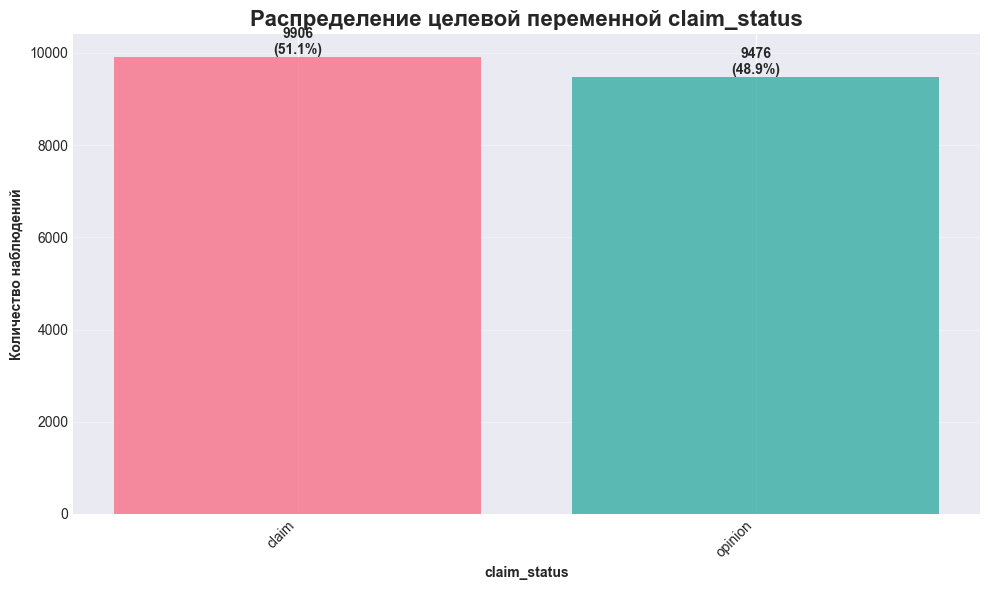

In [28]:
# 2.3 Анализ баланса классов (если есть целевая переменная)
# Ищем возможные целевые переменные
target_candidates = [col for col in df.columns if any(keyword in col.lower() 
                    for keyword in ['target', 'label', 'class', 'outcome', 'result', 'status'])]

print("\n2.3 Поиск целевой переменной:")
if target_candidates:
    print(f"Найдены возможные целевые переменные: {target_candidates}")
    # Берем первую найденную
    target_var = target_candidates[0]
    print(f"\nАнализируем переменную: {target_var}")
    
    target_counts = df[target_var].value_counts()
    target_percentage = df[target_var].value_counts(normalize=True) * 100
    
    print(f"Распределение {target_var}:")
    for val, count in target_counts.items():
        print(f"  {val}: {count} ({target_percentage[val]:.2f}%)")
    
    # Визуализация баланса классов
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("husl", len(target_counts))
    bars = plt.bar(range(len(target_counts)), target_counts.values, color=colors, alpha=0.8)
    
    plt.title(f'Распределение целевой переменной {target_var}', fontsize=16, fontweight='bold')
    plt.xlabel(target_var, fontweight='bold')
    plt.ylabel('Количество наблюдений', fontweight='bold')
    plt.xticks(range(len(target_counts)), target_counts.index, rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    
    # Добавление значений на столбцы
    for bar, count in zip(bars, target_counts.values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                 f'{count}\n({count/len(df)*100:.1f}%)',
                 ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('class_balance.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Целевая переменная не найдена автоматически.")
    print("Если есть целевая переменная, укажите её вручную для дальнейшего анализа.")


In [29]:
print("\n" + "=" * 80)
print("ПРОВЕРКА И ОЧИСТКА ДАННЫХ")
print("=" * 80)

# Проверяем числовые колонки на NaN и inf
print("\nПроверка числовых колонок на проблемы:")
numeric_cols = df.select_dtypes(include=[np.number]).columns
problems_found = False

for col in numeric_cols:
    nan_count = df[col].isna().sum()
    inf_count = np.isinf(df[col]).sum()
    if nan_count > 0 or inf_count > 0:
        problems_found = True
        print(f"  {col}: {nan_count} NaN, {inf_count} inf/ -inf")
        
        # Заменяем inf на NaN, затем заполняем
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)
        if df[col].isna().sum() > 0:
            median_val = df[col].median()
            if pd.notna(median_val):
                df[col].fillna(median_val, inplace=True)
                print(f"    Заполнено медианой: {median_val:.2f}")
            else:
                # Если медиана тоже NaN, заполняем 0
                df[col].fillna(0, inplace=True)
                print(f"    Заполнено нулем (медиана была NaN)")

if not problems_found:
    print("Проблем с числовыми колонками не обнаружено!")



ПРОВЕРКА И ОЧИСТКА ДАННЫХ

Проверка числовых колонок на проблемы:
Проблем с числовыми колонками не обнаружено!


## 3. ПРЕДВАРИТЕЛЬНЫЙ АНАЛИЗ


In [30]:
# 3. ПРЕДВАРИТЕЛЬНЫЙ АНАЛИЗ
print("\n" + "=" * 80)
print("3. ПРЕДВАРИТЕЛЬНЫЙ АНАЛИЗ")
print("=" * 80)

# 3.1 Анализ числовых переменных
print("\n3.1 Анализ числовых переменных:")

# Автоматически определяем типы переменных
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print(f"Найдено числовых переменных: {len(numeric_cols)}")
print(f"Найдено категориальных переменных: {len(categorical_cols)}")

# Для порядковых переменных - ищем колонки с небольшим количеством уникальных значений
ordinal_vars = []
continuous_vars = []

for col in numeric_cols:
    unique_count = df[col].nunique()
    if unique_count <= 10 and df[col].dtype in [np.int64, np.int32]:
        ordinal_vars.append(col)
    else:
        continuous_vars.append(col)

print(f"\nНепрерывных переменных: {len(continuous_vars)}")
print(f"Порядковых переменных: {len(ordinal_vars)}")

# ФИКС: Проверяем и преобразуем числовые колонки
print("\nПроверка типов данных для числовых переменных...")
for var in continuous_vars + ordinal_vars:
    if var in df.columns:
        if df[var].dtype == 'object':
            print(f"  Преобразуем {var} из {df[var].dtype} в числовой тип...")
            # Пробуем преобразовать в числовой тип, ошибки превращаем в NaN
            df[var] = pd.to_numeric(df[var], errors='coerce')
            
            # Заполняем пропущенные значения медианой
            if df[var].isnull().sum() > 0:
                median_val = df[var].median()
                if pd.notna(median_val):
                    df[var].fillna(median_val, inplace=True)
                    print(f"    Заполнено {df[var].isnull().sum()} пропусков медианой: {median_val}")
                else:
                    df[var].fillna(0, inplace=True)
                    print(f"    Заполнено нулем (медиана была NaN)")



3. ПРЕДВАРИТЕЛЬНЫЙ АНАЛИЗ

3.1 Анализ числовых переменных:
Найдено числовых переменных: 10
Найдено категориальных переменных: 4

Непрерывных переменных: 10
Порядковых переменных: 0

Проверка типов данных для числовых переменных...


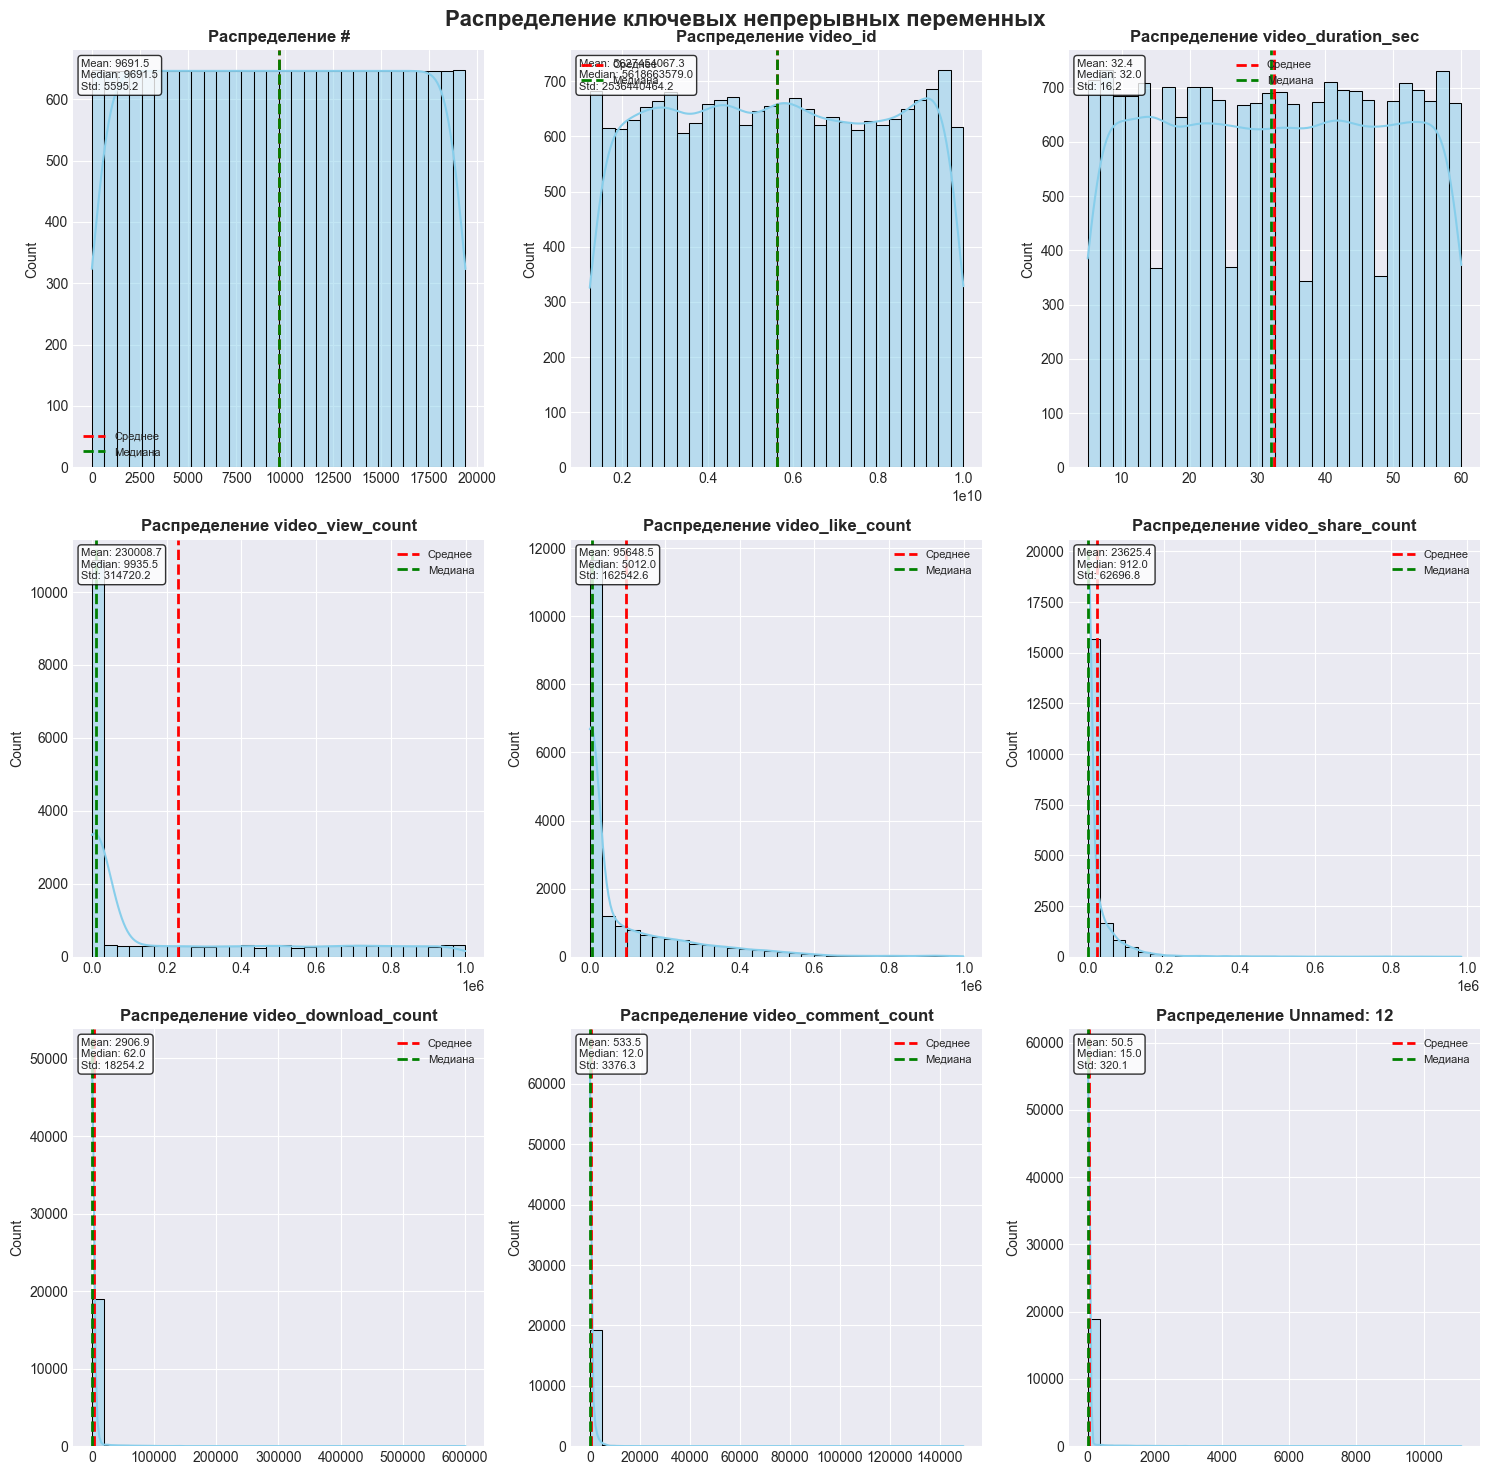

In [31]:
# Визуализация распределения ключевых непрерывных переменных
if len(continuous_vars) > 0:
    # Берем первые 9 переменных для визуализации
    key_continuous = continuous_vars[:9]
    
    # ФИКС: Фильтруем только существующие переменные
    key_continuous = [var for var in key_continuous if var in df.columns]
    
    if len(key_continuous) > 0:
        n_plots = len(key_continuous)
        n_rows = (n_plots + 2) // 3  # Округляем вверх
        fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
        
        # Если только одна строка, делаем axes двумерным
        if n_rows == 1:
            axes = axes.reshape(1, -1)
        
        for idx, var in enumerate(key_continuous):
            row = idx // 3
            col = idx % 3
            
            # Проверяем, что переменная числовая
            if pd.api.types.is_numeric_dtype(df[var]):
                # Гистограмма с KDE
                ax = axes[row, col]
                
                # ФИКС: Убедимся, что данные числовые
                data_to_plot = pd.to_numeric(df[var], errors='coerce').dropna()
                
                if len(data_to_plot) > 0:
                    sns.histplot(data_to_plot, kde=True, ax=ax, bins=30, color='skyblue', edgecolor='black')
                    ax.axvline(data_to_plot.mean(), color='red', linestyle='--', linewidth=2, label='Среднее')
                    ax.axvline(data_to_plot.median(), color='green', linestyle='--', linewidth=2, label='Медиана')
                    
                    ax.set_title(f'Распределение {var}', fontweight='bold')
                    ax.set_xlabel('')
                    ax.legend(fontsize=8)
                    
                    # Добавление статистик
                    stats_text = f'Mean: {data_to_plot.mean():.1f}\nMedian: {data_to_plot.median():.1f}\nStd: {data_to_plot.std():.1f}'
                    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, 
                            fontsize=8, verticalalignment='top',
                            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                else:
                    ax.text(0.5, 0.5, f'Нет данных для {var}', 
                            transform=ax.transAxes, ha='center', va='center')
                    ax.set_title(f'Распределение {var}', fontweight='bold')
            else:
                # Если переменная не числовая
                ax = axes[row, col]
                ax.text(0.5, 0.5, f'{var} не числовая\nТип: {df[var].dtype}', 
                        transform=ax.transAxes, ha='center', va='center')
                ax.set_title(f'Распределение {var}', fontweight='bold')
        
        # Скрываем пустые оси, если переменных меньше 9
        for idx in range(len(key_continuous), n_rows * 3):
            row = idx // 3
            col = idx % 3
            if row < n_rows:
                axes[row, col].set_visible(False)
        
        plt.suptitle('Распределение ключевых непрерывных переменных', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('continuous_vars_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("Нет непрерывных переменных для визуализации")
else:
    print("Непрерывные переменные не найдены")


In [32]:
# 3.2 Анализ порядковых переменных
print("\n3.2 Анализ порядковых (ординальных) переменных:")

if len(ordinal_vars) > 0:
    # Берем первые 9 порядковых переменных
    vars_to_plot = ordinal_vars[:9]
    
    n_plots = len(vars_to_plot)
    n_rows = (n_plots + 2) // 3
    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
    
    # Если только одна строка, делаем axes двумерным
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, var in enumerate(vars_to_plot):
        if var not in df.columns:
            continue
            
        row = idx // 3
        col = idx % 3
        ax = axes[row, col]
        
        value_counts = df[var].value_counts().sort_index()
        
        bars = ax.bar(range(len(value_counts)), value_counts.values, 
                      color=plt.cm.Set3(np.arange(len(value_counts))/len(value_counts)))
        ax.set_title(f'{var} Distribution', fontweight='bold')
        ax.set_xlabel('Уровень/Оценка')
        ax.set_ylabel('Количество')
        ax.set_xticks(range(len(value_counts)))
        ax.set_xticklabels(value_counts.index, rotation=45, ha='right')
        
        # Добавление процентов
        total = len(df)
        for i, (x_pos, count) in enumerate(zip(range(len(value_counts)), value_counts.values)):
            percentage = (count / total) * 100
            ax.text(x_pos, count + 0.02 * max(value_counts.values), 
                    f'{percentage:.1f}%', ha='center', va='bottom', fontsize=8)
    
    # Скрываем пустые оси
    for idx in range(len(vars_to_plot), n_rows * 3):
        row = idx // 3
        col = idx % 3
        if row < n_rows:
            axes[row, col].set_visible(False)
    
    plt.suptitle('Распределение порядковых переменных', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('ordinal_vars_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Порядковые переменные не найдены")



3.2 Анализ порядковых (ординальных) переменных:
Порядковые переменные не найдены



3.3 Сравнение ключевых показателей по группам:
Используем целевую переменную: claim_status
Группы в целевой переменной: ['claim' 'opinion']
Анализируем 9 переменных
#: claim (n=9906): mean=5238.56, opinion (n=9476): mean=14346.50, p=0.0000
video_id: claim (n=9906): mean=5632306230.26, opinion (n=9476): mean=5622381723.96, p=0.7854
video_duration_sec: claim (n=9906): mean=32.48, opinion (n=9476): mean=32.36, p=0.6037
video_view_count: claim (n=9906): mean=444911.41, opinion (n=9476): mean=5354.15, p=0.0000
video_like_count: claim (n=9906): mean=185788.29, opinion (n=9476): mean=1418.31, p=0.0000
video_share_count: claim (n=9906): mean=45911.87, opinion (n=9476): mean=327.55, p=0.0000
video_download_count: claim (n=9906): mean=5650.79, opinion (n=9476): mean=38.59, p=0.0000
video_comment_count: claim (n=9906): mean=1038.17, opinion (n=9476): mean=5.96, p=0.0000
Unnamed: 12: claim (n=9906): mean=85.33, opinion (n=9476): mean=14.12, p=0.0000


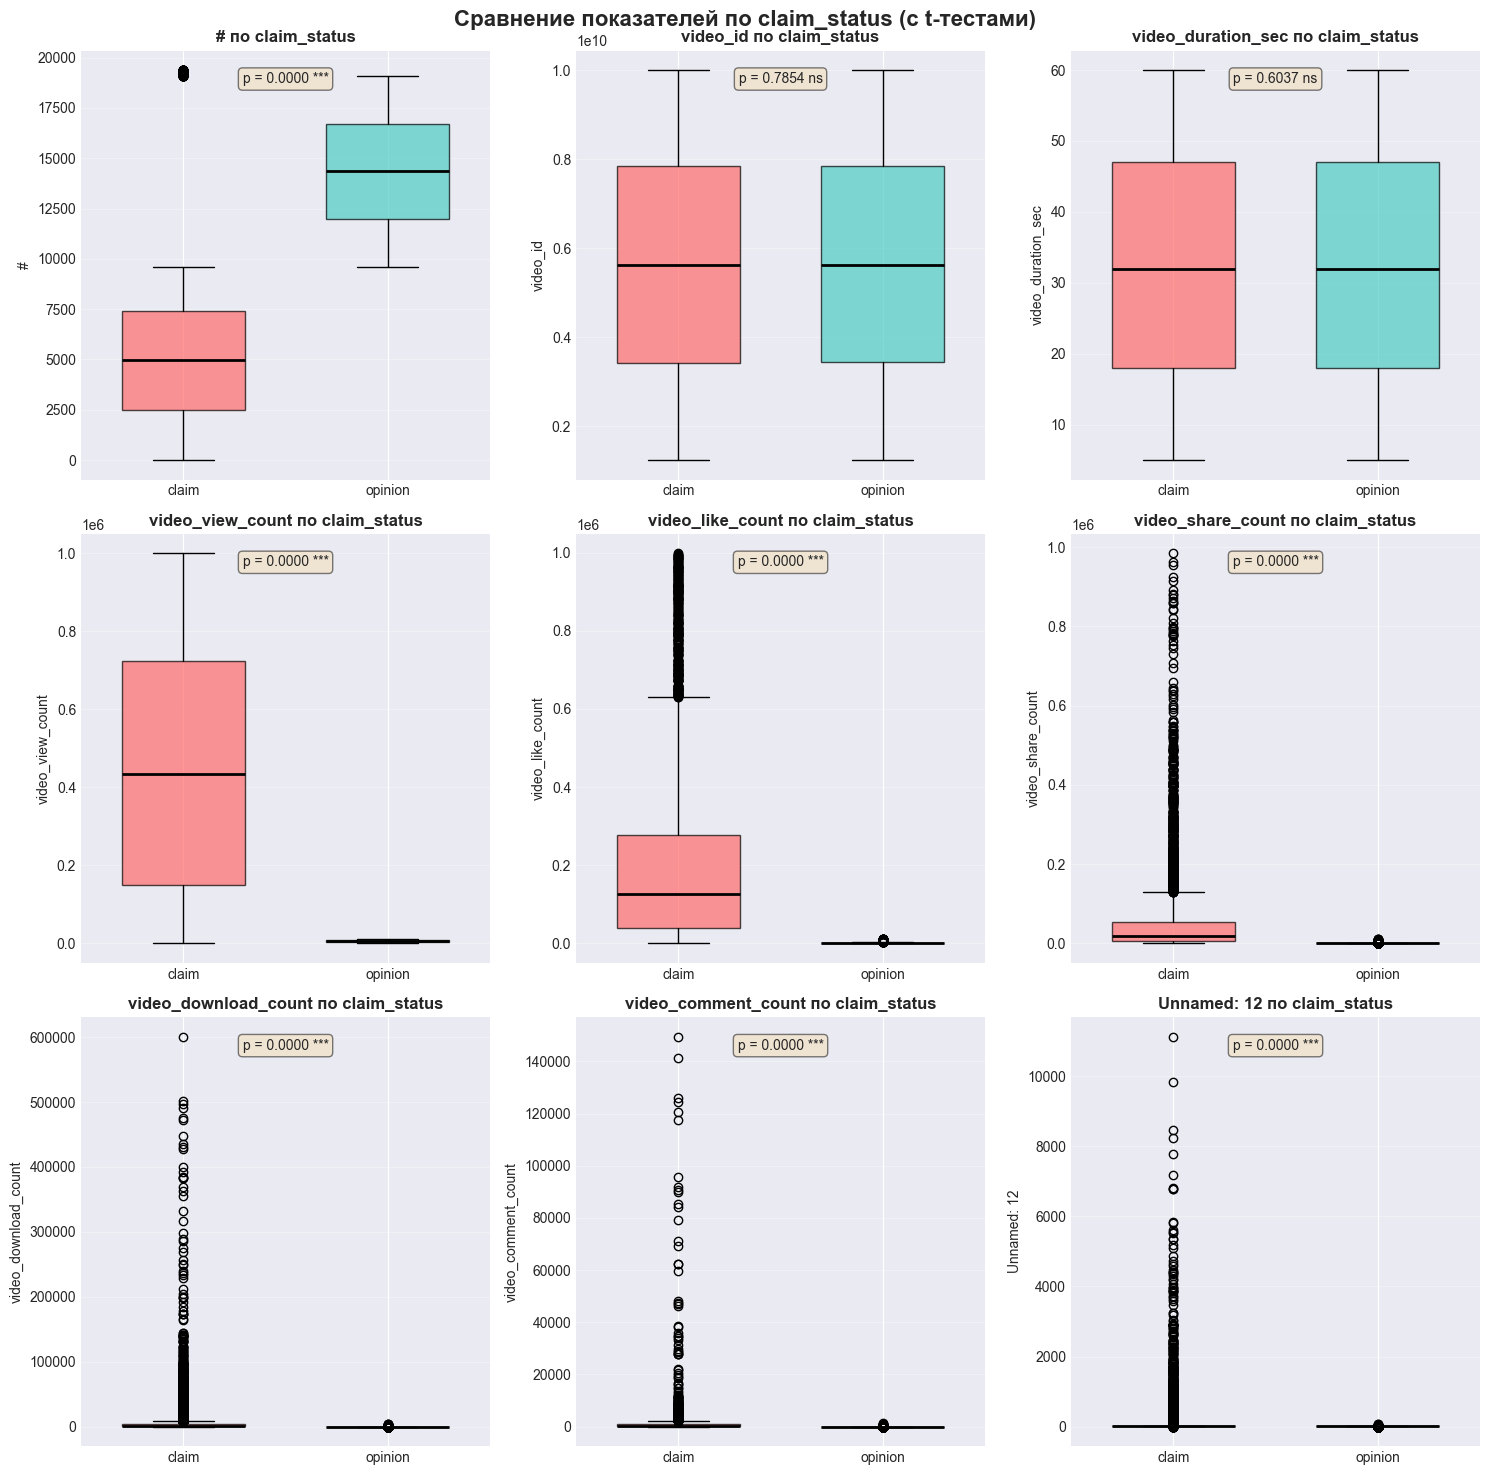

In [33]:
# 3.3 Сравнение по группам (если есть целевая переменная)
print("\n3.3 Сравнение ключевых показателей по группам:")

# Ищем целевую переменную
target_var = None
if target_candidates:
    target_var = target_candidates[0]
    print(f"Используем целевую переменную: {target_var}")
    
    # Получаем уникальные значения целевой переменной
    target_values = df[target_var].unique()
    print(f"Группы в целевой переменной: {target_values}")
    
    if len(target_values) >= 2:
        # Берем первые 9 числовых переменных для сравнения
        comparison_vars = continuous_vars[:9] if len(continuous_vars) >= 9 else continuous_vars
        
        # Фильтруем только существующие и числовые переменные
        valid_comparison_vars = []
        for var in comparison_vars:
            if var in df.columns and pd.api.types.is_numeric_dtype(df[var]):
                valid_comparison_vars.append(var)
        
        print(f"Анализируем {len(valid_comparison_vars)} переменных")
        
        if len(valid_comparison_vars) > 0:
            n_plots = min(len(valid_comparison_vars), 9)
            n_rows = (n_plots + 2) // 3
            fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
            
            # Если только одна строка, делаем axes двумерным
            if n_rows == 1:
                axes = axes.reshape(1, -1)
            
            for idx, var in enumerate(valid_comparison_vars):
                if idx >= 9:  # Максимум 9 графиков
                    break
                    
                row = idx // 3
                col = idx % 3
                ax = axes[row, col]
                
                try:
                    # Создаем данные для boxplot
                    plot_data = []
                    groups = []
                    
                    # Берем первые два значения целевой переменной для сравнения
                    for target_val in target_values[:2]:
                        # Фильтруем данные для каждой группы
                        mask = (df[target_var] == target_val)
                        subset = df.loc[mask, var]
                        
                        # Удаляем NaN и бесконечные значения
                        subset_clean = subset.replace([np.inf, -np.inf], np.nan).dropna()
                        
                        if len(subset_clean) > 0:
                            plot_data.append(subset_clean)
                            groups.append(str(target_val))
                    
                    if len(plot_data) == 2 and len(plot_data[0]) > 0 and len(plot_data[1]) > 0:
                        # Boxplot
                        bp = ax.boxplot(plot_data, labels=groups, patch_artist=True, widths=0.6)
                        
                        # Настройка цветов
                        colors = ['#FF6B6B', '#4ECDC4']
                        for patch, color in zip(bp['boxes'], colors[:len(bp['boxes'])]):
                            patch.set_facecolor(color)
                            patch.set_alpha(0.7)
                        
                        # Медианы
                        for median in bp['medians']:
                            median.set(color='black', linewidth=2)
                        
                        ax.set_title(f'{var} по {target_var}', fontweight='bold')
                        ax.set_ylabel(var)
                        ax.grid(True, alpha=0.3, axis='y')
                        
                        # Добавление t-test статистики
                        try:
                            group1_data = df[df[target_var] == target_values[0]][var].replace([np.inf, -np.inf], np.nan).dropna()
                            group2_data = df[df[target_var] == target_values[1]][var].replace([np.inf, -np.inf], np.nan).dropna()
                            
                            if len(group1_data) > 1 and len(group2_data) > 1:
                                t_stat, p_value = stats.ttest_ind(group1_data, group2_data, equal_var=False, nan_policy='omit')
                                stars = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'
                                ax.text(0.5, 0.95, f'p = {p_value:.4f} {stars}', 
                                        transform=ax.transAxes, ha='center', va='top',
                                        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
                                
                                # Вывод статистики в консоль
                                print(f"{var}: {target_values[0]} (n={len(group1_data)}): mean={group1_data.mean():.2f}, "
                                      f"{target_values[1]} (n={len(group2_data)}): mean={group2_data.mean():.2f}, p={p_value:.4f}")
                        except Exception as e:
                            print(f"  Ошибка t-теста для {var}: {str(e)}")
                    else:
                        ax.text(0.5, 0.5, 'Недостаточно данных', 
                                transform=ax.transAxes, ha='center', va='center')
                        ax.set_title(f'{var} по {target_var}', fontweight='bold')
                        ax.set_ylabel(var)
                        
                except Exception as e:
                    ax.text(0.5, 0.5, f'Ошибка: {str(e)[:30]}...', 
                            transform=ax.transAxes, ha='center', va='center')
                    ax.set_title(f'{var} по {target_var}', fontweight='bold')
                    ax.set_ylabel(var)
            
            # Скрываем пустые оси
            for idx in range(len(valid_comparison_vars), n_rows * 3):
                row = idx // 3
                col = idx % 3
                if row < n_rows:
                    axes[row, col].set_visible(False)
            
            plt.suptitle(f'Сравнение показателей по {target_var} (с t-тестами)', fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.savefig('target_comparison_ttest.png', dpi=300, bbox_inches='tight')
            plt.show()
        else:
            print("Нет подходящих переменных для сравнения")
    else:
        print(f"Целевая переменная имеет менее 2 групп ({len(target_values)}), сравнение невозможно")
else:
    print("Целевая переменная не найдена, пропускаем сравнение по группам")


## 4. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ



4. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ
Уникальные значения claim_status_numeric: [0 1]

Используем 11 числовых переменных для корреляционного анализа

Размер корреляционной матрицы: (11, 11)


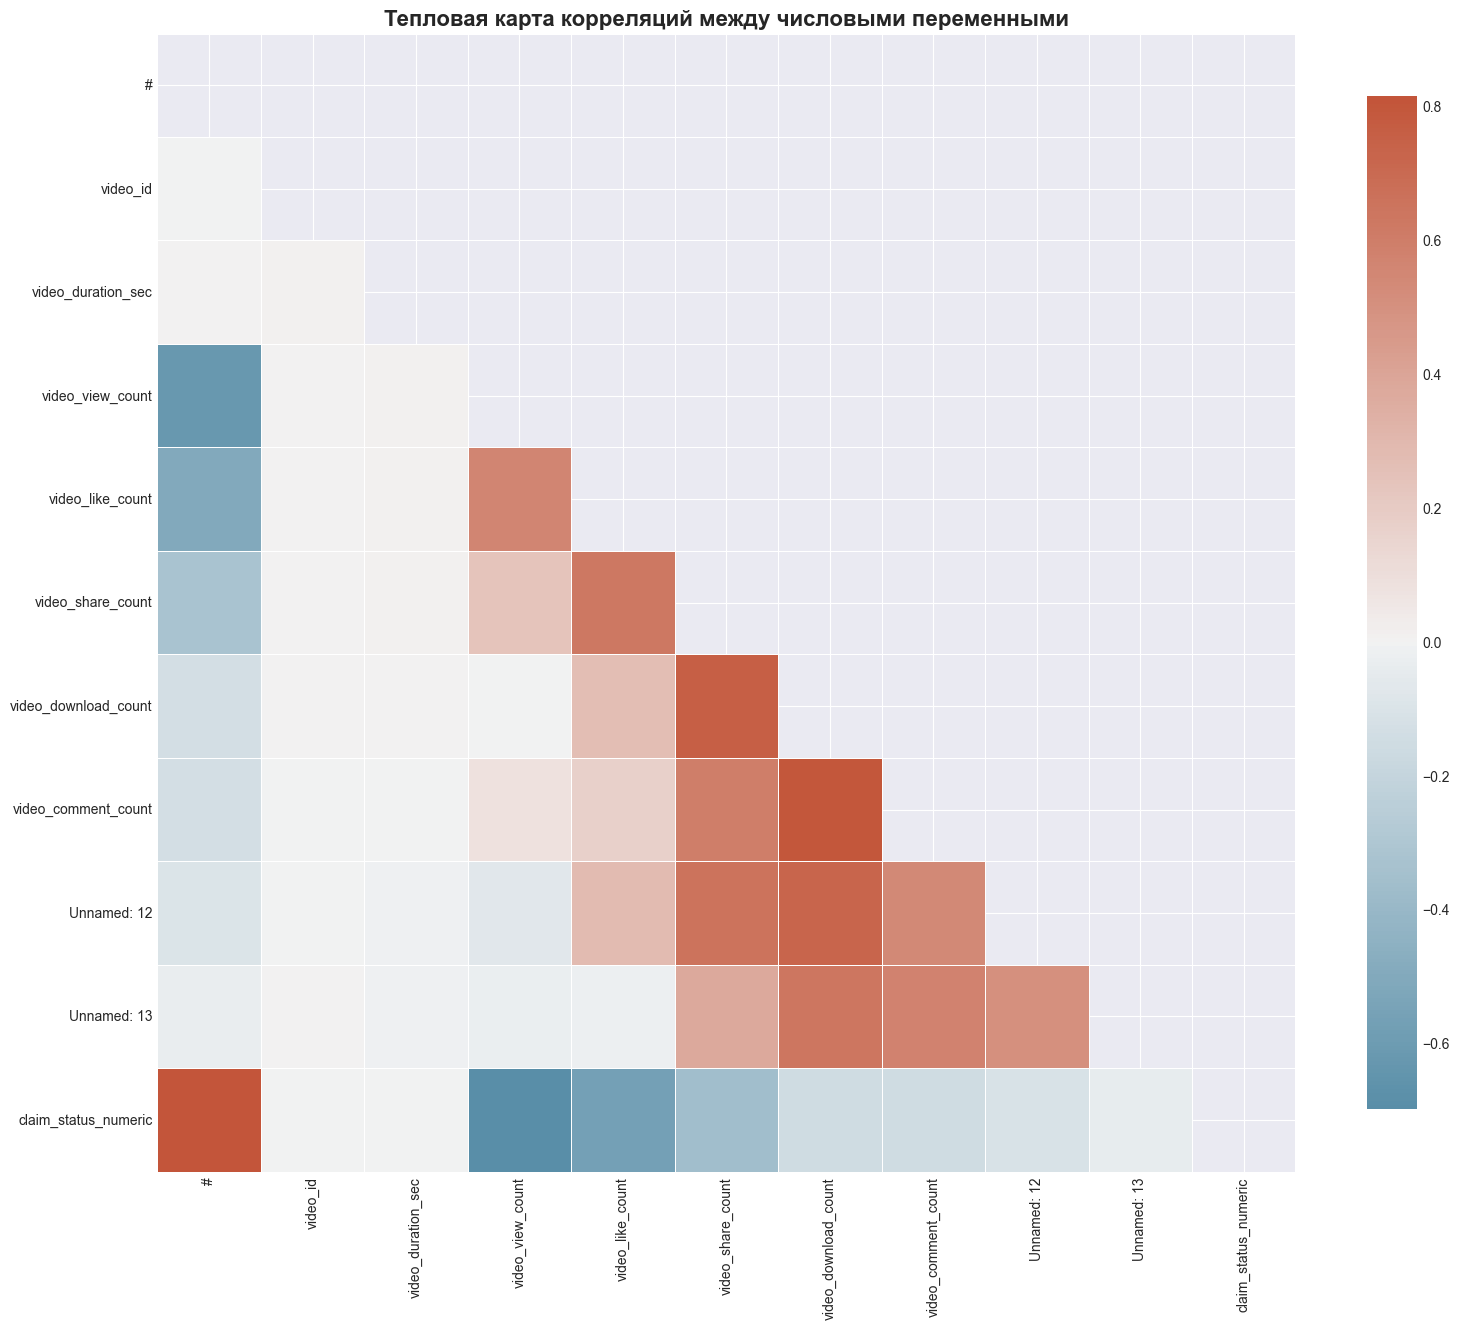

In [34]:
# 4. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ
print("\n" + "=" * 80)
print("4. КОРРЕЛЯЦИОННЫЙ АНАЛИЗ")
print("=" * 80)

# Создаем числовую версию целевой переменной (если найдена)
df_numeric = df.copy()

# Создаем числовую версию целевой переменной
target_var_numeric = None
if target_candidates:
    target_var = target_candidates[0]
    target_var_numeric = f"{target_var}_numeric"
    
    # Приводим к стандартному виду
    if df_numeric[target_var].dtype == 'object':
        df_numeric[target_var] = df_numeric[target_var].astype(str).str.strip().str.title()
        
        # Создаем числовую версию
        # Определяем уникальные значения и создаем маппинг
        unique_vals = df_numeric[target_var].unique()
        target_map = {}
        for i, val in enumerate(sorted(unique_vals)):
            target_map[val] = i
        
        df_numeric[target_var_numeric] = df_numeric[target_var].map(target_map)
        
        # Проверяем результат
        print(f"Уникальные значения {target_var_numeric}: {df_numeric[target_var_numeric].unique()}")
        
        # Если есть NaN, заполняем наиболее частым значением
        if df_numeric[target_var_numeric].isnull().sum() > 0:
            print(f"Предупреждение: {df_numeric[target_var_numeric].isnull().sum()} строк с некорректными значениями {target_var}")
            mode_val = df_numeric[target_var_numeric].mode()[0] if not df_numeric[target_var_numeric].mode().empty else 0
            df_numeric[target_var_numeric].fillna(mode_val, inplace=True)
            print(f"  Заполнено значением: {mode_val}")
    else:
        # Если уже числовая, просто копируем
        df_numeric[target_var_numeric] = df_numeric[target_var]
        print(f"Целевая переменная {target_var} уже числовая")
else:
    print("Целевая переменная не найдена, корреляционный анализ будет без целевой переменной")

# Выбираем числовые колонки для корреляционного анализа
numeric_for_corr = []
for var in continuous_vars + ordinal_vars:
    if var in df_numeric.columns and pd.api.types.is_numeric_dtype(df_numeric[var]):
        numeric_for_corr.append(var)

# Добавляем целевую переменную, если она есть
if target_var_numeric and target_var_numeric in df_numeric.columns:
    numeric_for_corr.append(target_var_numeric)

print(f"\nИспользуем {len(numeric_for_corr)} числовых переменных для корреляционного анализа")

# Проверяем, что достаточно данных
if len(numeric_for_corr) < 2:
    print("ОШИБКА: Недостаточно числовых переменных для корреляционного анализа!")
else:
    # Создаем корреляционную матрицу
    corr_matrix = df_numeric[numeric_for_corr].corr()
    
    print(f"\nРазмер корреляционной матрицы: {corr_matrix.shape}")
    
    # 4.1 Тепловая карта всех корреляций
    plt.figure(figsize=(16, 14))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                annot=False)
    
    plt.title('Тепловая карта корреляций между числовыми переменными', 
              fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('full_correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()



4.2 Переменные с наибольшей корреляцией с claim_status:

Топ-10 положительных корреляций:
claim_status_numeric    1.000000
#                       0.813720
video_id               -0.001956
video_duration_sec     -0.003729
Unnamed: 13            -0.037093
Unnamed: 12            -0.111190
video_comment_count    -0.152827
video_download_count   -0.153689
video_share_count      -0.363450
video_like_count       -0.567019
video_view_count       -0.698176

Топ-10 отрицательных корреляций:
video_view_count       -0.698176
video_like_count       -0.567019
video_share_count      -0.363450
video_download_count   -0.153689
video_comment_count    -0.152827
Unnamed: 12            -0.111190
Unnamed: 13            -0.037093
video_duration_sec     -0.003729
video_id               -0.001956
#                       0.813720


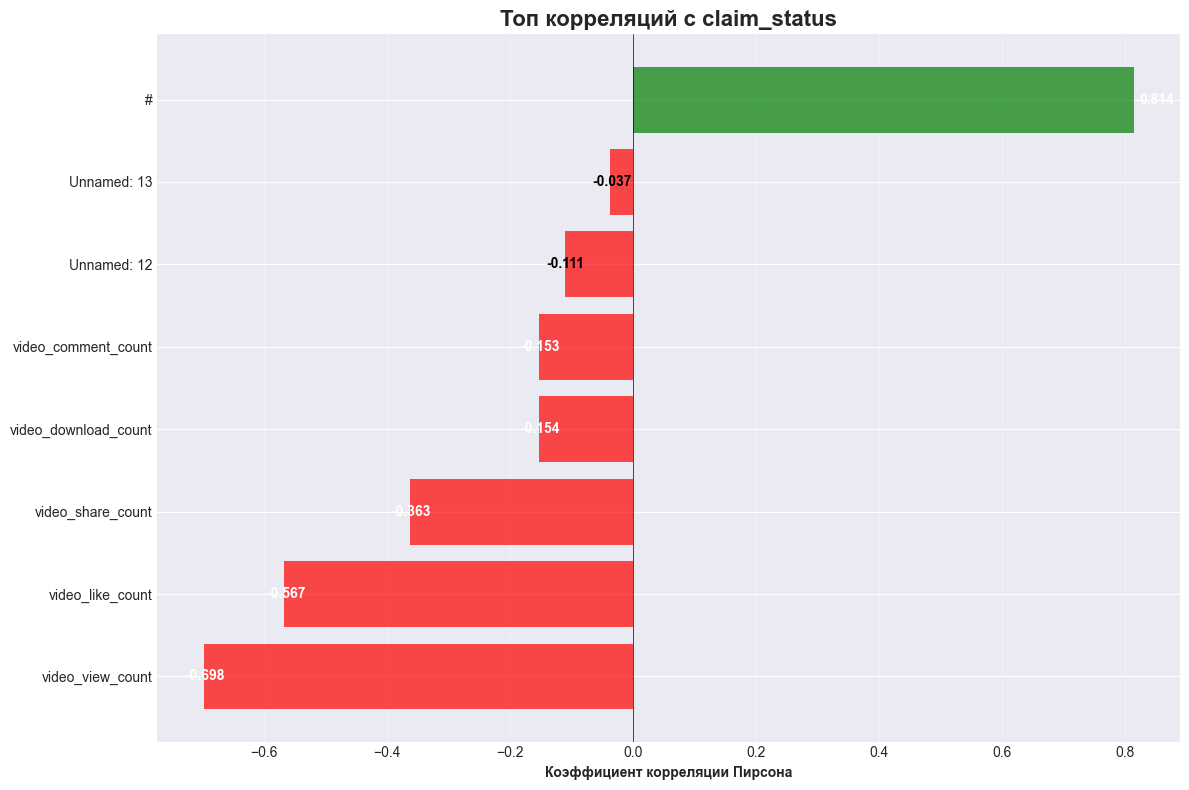

In [35]:
# 4.2 Корреляции с целевой переменной (если есть)
if 'corr_matrix' in locals() and target_var_numeric and target_var_numeric in corr_matrix.columns and 'target_var' in locals():
    print(f"\n4.2 Переменные с наибольшей корреляцией с {target_var}:")
    target_corr = corr_matrix[target_var_numeric].sort_values(ascending=False)
    
    # Топ положительных и отрицательных корреляций
    print("\nТоп-10 положительных корреляций:")
    top_pos = target_corr.head(11)  # 11 потому что первое - сама целевая переменная
    print(top_pos.to_string())
    
    print("\nТоп-10 отрицательных корреляций:")
    top_neg = target_corr.tail(10).sort_values(ascending=True)
    print(top_neg.to_string())
    
    # Визуализация топ-15 корреляций с целевой переменной
    # Исключаем саму целевую переменную
    top_corr_values = target_corr.drop(target_var_numeric, errors='ignore')
    
    if len(top_corr_values) > 0:
        # Берем топ 8 положительных и топ 7 отрицательных
        n_pos = min(8, len(top_corr_values[top_corr_values > 0]))
        n_neg = min(7, len(top_corr_values[top_corr_values < 0]))
        
        top_pos = top_corr_values[top_corr_values > 0].head(n_pos)
        top_neg = top_corr_values[top_corr_values < 0].tail(n_neg)
        
        top_corr = pd.concat([top_pos, top_neg]).sort_values()
        
        plt.figure(figsize=(12, 8))
        
        colors = ['red' if x < 0 else 'green' for x in top_corr.values]
        bars = plt.barh(range(len(top_corr)), top_corr.values, color=colors, alpha=0.7)
        
        plt.yticks(range(len(top_corr)), top_corr.index)
        plt.xlabel('Коэффициент корреляции Пирсона', fontweight='bold')
        plt.title(f'Топ корреляций с {target_var}', fontsize=16, fontweight='bold')
        plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
        plt.grid(axis='x', alpha=0.3)
        
        # Добавление значений
        for i, (bar, val) in enumerate(zip(bars, top_corr.values)):
            plt.text(val + (0.01 if val >= 0 else -0.03), i, 
                     f'{val:.3f}', 
                     va='center', 
                     color='black' if abs(val) < 0.15 else 'white',
                     fontweight='bold')
        
        plt.tight_layout()
        plt.savefig('top_correlations_with_target.png', dpi=300, bbox_inches='tight')
        plt.show()
    else:
        print("\nНет корреляций для визуализации")
else:
    print(f"\n{target_var_numeric if target_var_numeric else 'Целевая переменная'} не найдена в корреляционной матрице")


## 5. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ


In [36]:
# 5. АНАЛИЗ КАТЕГОРИАЛЬНЫХ (БИНАРНЫХ) ПЕРЕМЕННЫХ
print("\n" + "=" * 80)
print("5. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ")
print("=" * 80)

# Определяем бинарные переменные (категориальные с небольшим количеством уникальных значений)
binary_vars = []
for col in categorical_cols:
    unique_count = df[col].nunique()
    if 2 <= unique_count <= 10:  # Бинарные или категориальные с небольшим количеством значений
        binary_vars.append(col)

print(f"\nНайдено {len(binary_vars)} категориальных переменных для анализа")

# 5.1 Анализ влияния бинарных переменных на целевую переменную
if target_candidates:
    target_var = target_candidates[0]
    print(f"\n5.1 Влияние категориальных переменных на {target_var}:")
    
    # Функция для расчета отношения шансов (Odds Ratio)
    def calculate_odds_ratio(df, variable, target):
        try:
            # Создаем временный DataFrame
            temp_df = df[[variable, target]].copy()
            
            # Убедимся, что target в правильном формате
            if temp_df[target].dtype == 'object':
                # Преобразуем target в бинарный
                temp_df[target] = temp_df[target].astype(str).str.strip().str.title()
                unique_target_vals = temp_df[target].unique()
                if len(unique_target_vals) == 2:
                    target_map = {str(unique_target_vals[0]): 0, str(unique_target_vals[1]): 1}
                    temp_df[target] = temp_df[target].map(target_map)
                else:
                    # Если больше 2 значений, берем два самых частых
                    value_counts = temp_df[target].value_counts()
                    top_values = value_counts.index[:2].tolist()
                    target_map = {str(top_values[0]): 0, str(top_values[1]): 1}
                    for val in unique_target_vals:
                        if str(val) not in target_map:
                            target_map[str(val)] = 0
                    temp_df[target] = temp_df[target].map(target_map)
            
            # Удаляем строки с NaN в целевой переменной
            temp_df = temp_df.dropna(subset=[target])
            
            if len(temp_df) < 10:  # Минимальное количество данных
                return None
            
            # Для переменной: если это число, используем как есть
            if pd.api.types.is_numeric_dtype(temp_df[variable]):
                # Проверяем, что значения 0 и 1
                unique_vals = temp_df[variable].dropna().unique()
                unique_vals = [v for v in unique_vals if not pd.isna(v)]
                
                if len(unique_vals) == 2 and set(unique_vals).issubset({0, 1}):
                    # Уже бинарная
                    pass
                else:
                    # Преобразуем в бинарную (медиана как порог)
                    median_val = temp_df[variable].median()
                    temp_df[variable] = (temp_df[variable] > median_val).astype(int)
            else:
                # Если не числовая, преобразуем в бинарную
                unique_vals = temp_df[variable].dropna().unique()
                unique_vals = [str(v) for v in unique_vals if not pd.isna(v)]
                
                if len(unique_vals) >= 2:
                    # Берем два самых частых значения
                    value_counts = temp_df[variable].value_counts()
                    top_values = value_counts.index[:2].tolist()
                    
                    # Создаем mapping
                    val_map = {str(top_values[0]): 0, str(top_values[1]): 1}
                    for val in unique_vals:
                        if str(val) not in val_map:
                            val_map[str(val)] = 0  # остальные относим к группе 0
                    
                    temp_df[variable] = temp_df[variable].astype(str).map(val_map)
                else:
                    return None
            
            # Удаляем строки с NaN в переменной
            temp_df = temp_df.dropna(subset=[variable])
            
            if len(temp_df) < 10:  # Слишком мало данных
                return None
            
            # Создаем таблицу сопряженности
            contingency_table = pd.crosstab(temp_df[variable], temp_df[target])
            
            # Убедимся, что таблица 2x2
            if contingency_table.shape != (2, 2):
                # Если не 2x2, возможно нужно перекодировать
                if len(contingency_table) == 2 and len(contingency_table.columns) == 2:
                    pass  # Уже 2x2
                else:
                    return None
            
            # Извлекаем значения
            try:
                a = contingency_table.loc[1, 1] if 1 in contingency_table.index else 0
                b = contingency_table.loc[1, 0] if 1 in contingency_table.index else 0
                c = contingency_table.loc[0, 1] if 0 in contingency_table.index else 0
                d = contingency_table.loc[0, 0] if 0 in contingency_table.index else 0
            except KeyError:
                return None
            
            # Расчет odds ratio с защитой от деления на 0
            if b == 0 or c == 0:
                odds_ratio = np.nan
            else:
                odds_ratio = (a * d) / (b * c)
            
            # Расчет rates
            target_rate_1 = a / (a + b) if (a + b) > 0 else 0
            target_rate_0 = c / (c + d) if (c + d) > 0 else 0
            
            return {
                'variable': variable,
                'odds_ratio': odds_ratio,
                'target_rate_1': target_rate_1,
                'target_rate_0': target_rate_0,
                'count_1': int(a + b),
                'count_0': int(c + d)
            }
        
        except Exception as e:
            return None
    
    # Анализ всех бинарных переменных
    odds_ratios = []
    print(f"Расчет odds ratios для категориальных переменных...")
    for idx, var in enumerate(binary_vars):
        if var in df.columns:
            result = calculate_odds_ratio(df, var, target_var)
            if result is not None and not pd.isna(result['odds_ratio']):
                odds_ratios.append(result)
    
    # Создаем DataFrame с результатами
    if odds_ratios:
        odds_df = pd.DataFrame(odds_ratios)
        
        # Проверяем, есть ли столбец odds_ratio
        if 'odds_ratio' in odds_df.columns and len(odds_df) > 0:
            # Удаляем строки с NaN в odds_ratio
            odds_df_clean = odds_df.dropna(subset=['odds_ratio'])
            
            if len(odds_df_clean) > 0:
                odds_df = odds_df_clean.sort_values('odds_ratio', ascending=False)
                
                print(f"\nНайдено {len(odds_df)} переменных с корректными odds ratios")
                print(f"\nТоп-10 отношений шансов (Odds Ratios) для категориальных переменных:")
                print(odds_df[['variable', 'odds_ratio', 'target_rate_1', 'target_rate_0']].head(10).to_string())
            else:
                print("\nНет корректных значений odds ratio для отображения")
                odds_df = pd.DataFrame()
        else:
            print("\nНе удалось рассчитать odds ratios")
            odds_df = pd.DataFrame()
    else:
        print("\nНе удалось рассчитать ни одного odds ratio")
        odds_df = pd.DataFrame()
else:
    print("\n5.1 Целевая переменная не найдена, пропускаем анализ odds ratios")
    odds_df = pd.DataFrame()



5. АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ

Найдено 2 категориальных переменных для анализа

5.1 Влияние категориальных переменных на claim_status:
Расчет odds ratios для категориальных переменных...

Найдено 1 переменных с корректными odds ratios

Топ-10 отношений шансов (Odds Ratios) для категориальных переменных:
            variable  odds_ratio  target_rate_1  target_rate_0
0  author_ban_status    0.268669       0.223967       0.517887


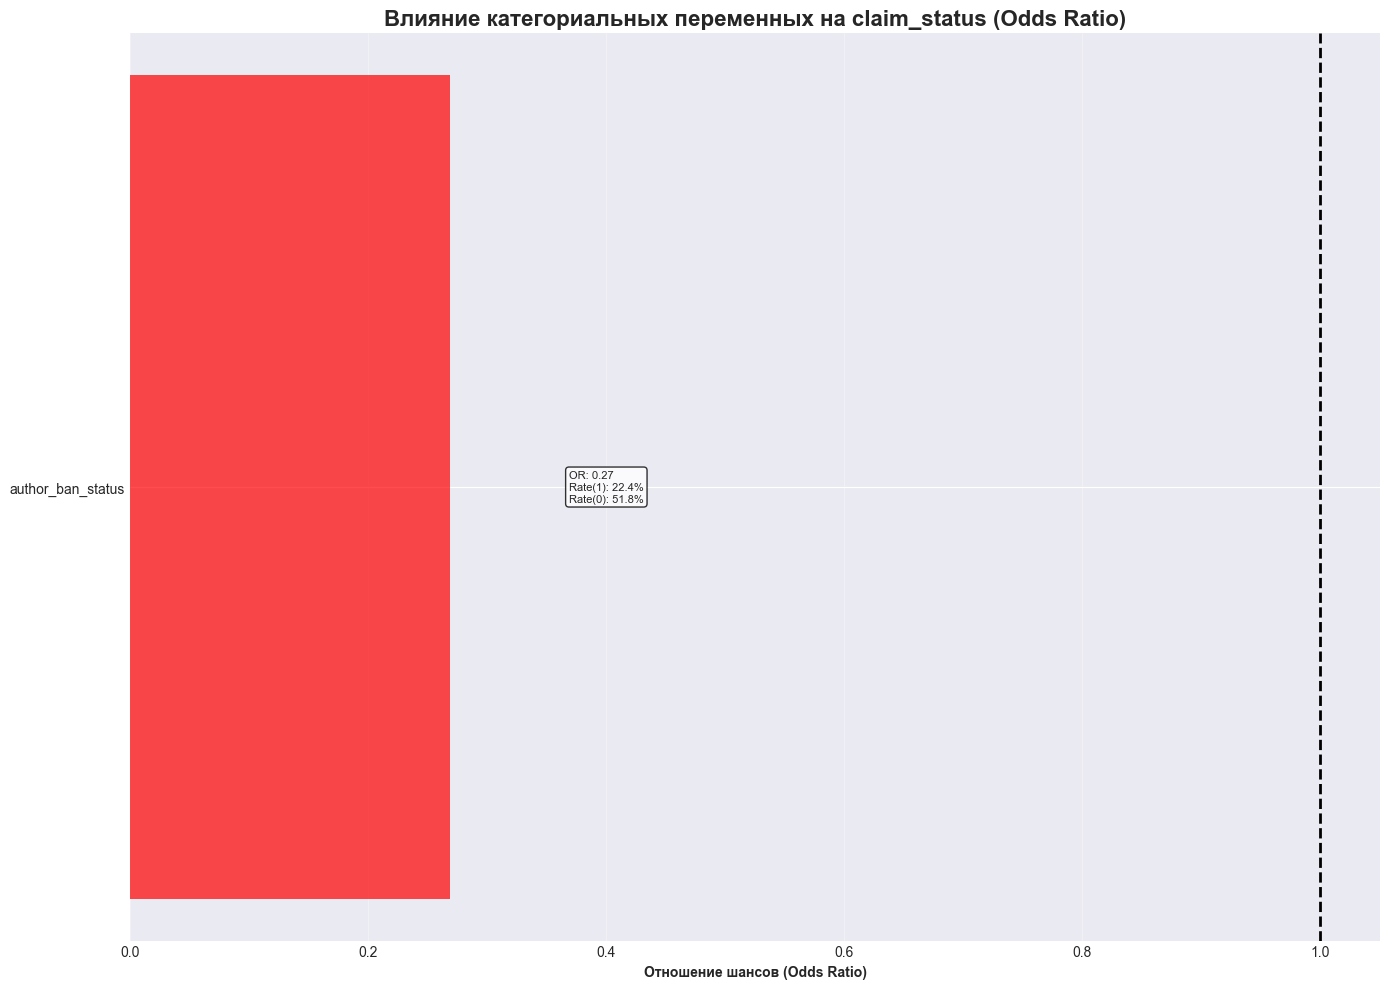

In [37]:
# 5.2 Визуализация отношения шансов
if not odds_df.empty and len(odds_df) > 0 and 'odds_ratio' in odds_df.columns:
    plt.figure(figsize=(14, 10))
    
    # Берем топ 15 или меньше
    n_to_show = min(15, len(odds_df))
    top_odds = odds_df.head(n_to_show).sort_values('odds_ratio')
    
    # Создаем горизонтальную диаграмму
    y_pos = np.arange(len(top_odds))
    colors = ['red' if x < 1 else 'green' for x in top_odds['odds_ratio']]
    
    bars = plt.barh(y_pos, top_odds['odds_ratio'], color=colors, alpha=0.7)
    
    plt.yticks(y_pos, top_odds['variable'])
    plt.xlabel('Отношение шансов (Odds Ratio)', fontweight='bold')
    plt.title(f'Влияние категориальных переменных на {target_var} (Odds Ratio)', 
              fontsize=16, fontweight='bold')
    plt.axvline(x=1, color='black', linestyle='--', linewidth=2)
    plt.grid(axis='x', alpha=0.3)
    
    # Добавление аннотаций
    for i, (bar, odds, rate1, rate0) in enumerate(zip(bars, top_odds['odds_ratio'], 
                                                       top_odds['target_rate_1'], 
                                                       top_odds['target_rate_0'])):
        annotation = f'OR: {odds:.2f}\nRate(1): {rate1:.1%}\nRate(0): {rate0:.1%}'
        x_pos = odds + 0.1 if odds < 10 else odds - 0.5
        plt.text(x_pos, i, 
                 annotation, 
                 va='center', fontsize=8,
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('odds_ratios_binary_vars.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("\nПропускаем визуализацию odds ratios: недостаточно данных")
    
    # Вместо этого создаем простую визуализацию целевой переменной по категориальным переменным
    if target_candidates:
        target_var = target_candidates[0]
        plt.figure(figsize=(14, 10))
        
        # Берем первые 6 категориальных переменных
        vars_to_plot = binary_vars[:6] if len(binary_vars) >= 6 else binary_vars
        
        if len(vars_to_plot) > 0:
            n_cols = 3
            n_rows = (len(vars_to_plot) + n_cols - 1) // n_cols
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
            
            if n_rows == 1:
                axes = axes.reshape(1, -1)
            axes = axes.flatten()
            
            for idx, var in enumerate(vars_to_plot):
                if idx < len(axes) and var in df.columns:
                    ax = axes[idx]
                    
                    try:
                        # Создаем сводную таблицу
                        temp_df = df[[var, target_var]].copy()
                        temp_df = temp_df.dropna()
                        
                        if len(temp_df) > 0:
                            # Для категориальных переменных
                            if temp_df[var].nunique() <= 10:
                                pivot = temp_df.groupby(var)[target_var].value_counts(normalize=True).unstack(fill_value=0)
                                
                                if len(pivot) > 0:
                                    # Берем первый столбец (первое значение целевой переменной)
                                    first_col = pivot.columns[0]
                                    pivot[first_col].plot(kind='bar', ax=ax, color='skyblue', alpha=0.7)
                                    ax.set_xlabel(var)
                                    ax.set_ylabel(f'Процент {target_var}')
                                    ax.set_title(f'{target_var} по {var}')
                                    ax.grid(axis='y', alpha=0.3)
                                    ax.tick_params(axis='x', rotation=45)
                                    
                                    # Добавить значения на столбцы
                                    for i, val in enumerate(pivot[first_col]):
                                        ax.text(i, val + 0.01, f'{val:.1%}', 
                                                ha='center', va='bottom', fontweight='bold', fontsize=8)
                                else:
                                    ax.text(0.5, 0.5, 'Недостаточно данных', 
                                            transform=ax.transAxes, ha='center', va='center')
                                    ax.set_title(f'{var}')
                            else:
                                ax.text(0.5, 0.5, 'Слишком много\nуникальных значений', 
                                        transform=ax.transAxes, ha='center', va='center')
                                ax.set_title(f'{var}')
                        else:
                            ax.text(0.5, 0.5, 'Нет данных', 
                                    transform=ax.transAxes, ha='center', va='center')
                            ax.set_title(f'{var}')
                    
                    except Exception as e:
                        ax.text(0.5, 0.5, f'Ошибка\n{str(e)[:20]}', 
                                transform=ax.transAxes, ha='center', va='center')
                        ax.set_title(f'{var}')
            
            # Скрыть пустые оси
            for idx in range(len(vars_to_plot), len(axes)):
                axes[idx].set_visible(False)
            
            plt.suptitle(f'Распределение {target_var} по категориальным переменным', fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.savefig('categorical_vars_target.png', dpi=300, bbox_inches='tight')
            plt.show()
        else:
            print("Нет категориальных переменных для визуализации")
    else:
        print("Целевая переменная не найдена, пропускаем визуализацию")


## 6. КЛАСТЕРНЫЙ АНАЛИЗ



6. КЛАСТЕРНЫЙ АНАЛИЗ

6.1 Подготовка данных для кластеризации...
Используем 10 признаков для кластеризации
Размер данных после удаления пропусков: (19382, 10)
Данные подготовлены и масштабированы

6.2 Определение оптимального числа кластеров...
k=2: WCSS=150253.75, Silhouette=0.916, DB=0.624
k=3: WCSS=113275.19, Silhouette=0.334, DB=1.136
k=4: WCSS=93801.73, Silhouette=0.332, DB=1.088
k=5: WCSS=84468.46, Silhouette=0.231, DB=1.188
k=6: WCSS=76768.16, Silhouette=0.223, DB=1.310
k=7: WCSS=71097.85, Silhouette=0.224, DB=1.328
k=8: WCSS=66094.21, Silhouette=0.218, DB=1.243
k=9: WCSS=61652.47, Silhouette=0.228, DB=1.241
k=10: WCSS=57821.90, Silhouette=0.230, DB=1.267


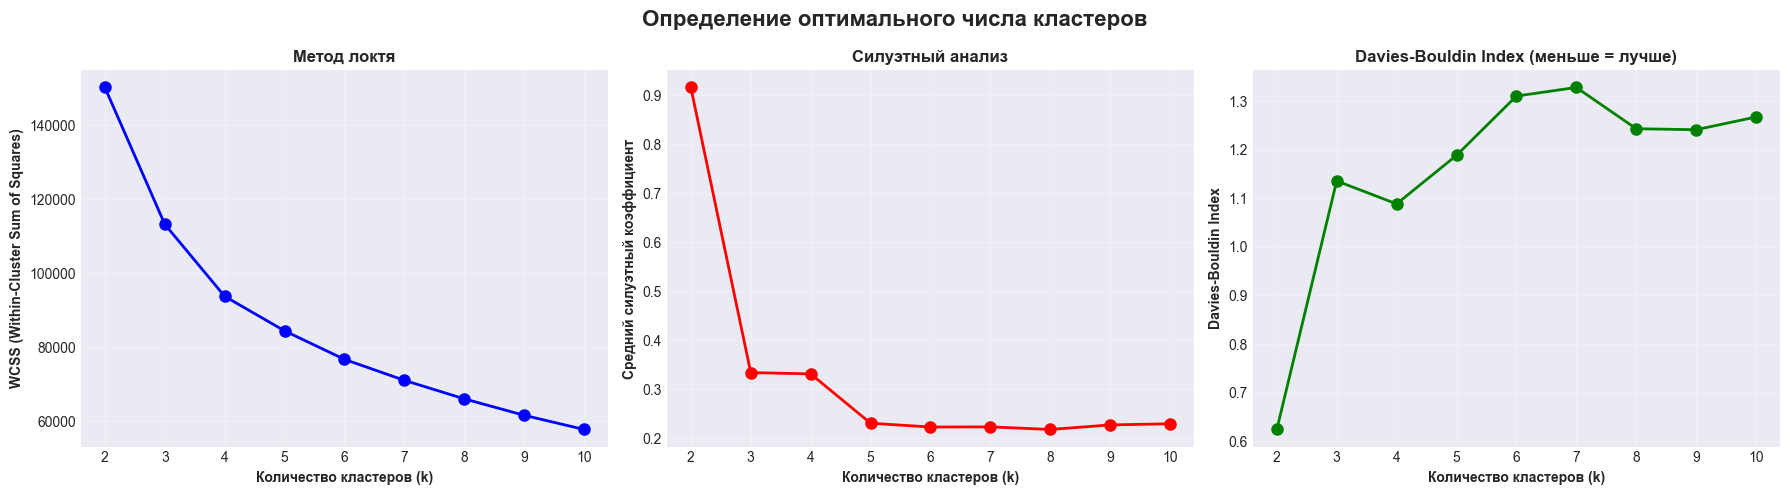


Оптимальное число кластеров (по силуэтному коэффициенту): 2

6.3 Применение K-means с k=2...
Кластеризация завершена. Создано 2 кластеров.

6.4 Снижение размерности и визуализация кластеров...
Объясненная дисперсия PCA: 0.582
PC1: 0.376
PC2: 0.206
Применение t-SNE...
t-SNE успешно выполнен


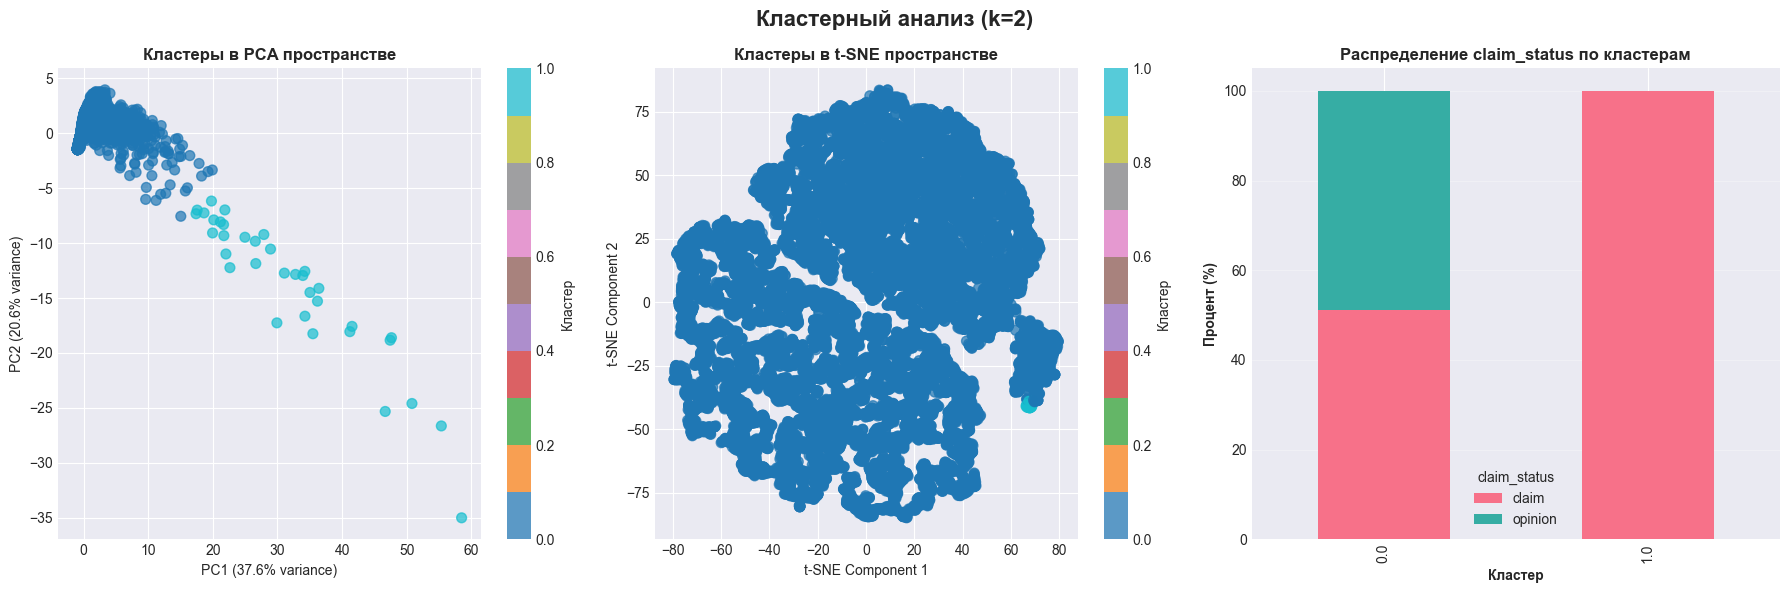


6.5 Характеристики кластеров:

Средние значения по кластерам для ключевых переменных:
               #      video_id  video_duration_sec  video_view_count  video_like_count  video_share_count  video_download_count  video_comment_count  Unnamed: 12  Unnamed: 13
Cluster                                                                                                                                                                       
0.0      9700.35  5.627218e+09               32.43         230406.81          95812.44           22350.35               2295.44               420.68        43.52         9.45
1.0      4798.26  5.758012e+09               29.74           9935.50           5012.00          728419.71             340929.37             62908.80      3915.31      1154.20

Размеры кластеров:
Cluster
0.0    19347
1.0       35
Name: count, dtype: int64

Процентное распределение:
  Кластер 0: 19347 (99.8%)
  Кластер 1: 35 (0.2%)


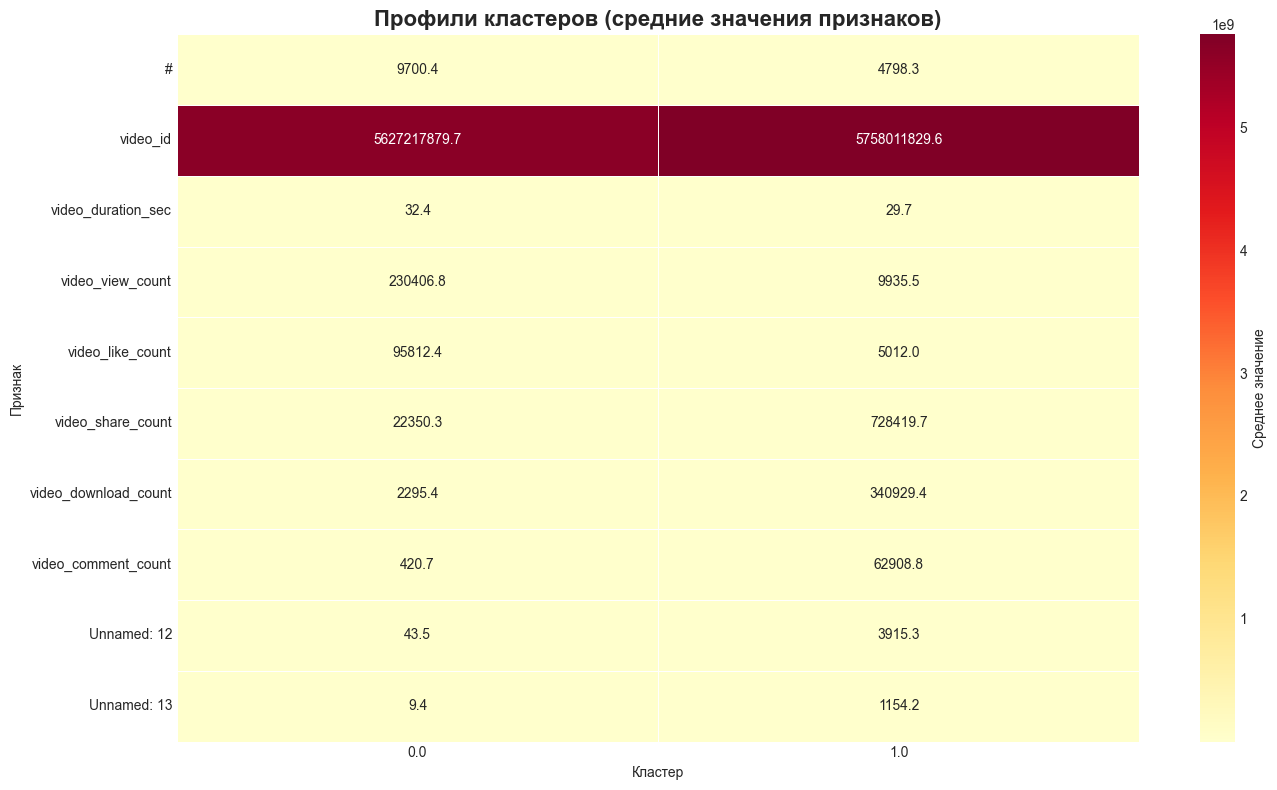

In [38]:
# 6. КЛАСТЕРНЫЙ АНАЛИЗ
print("\n" + "=" * 80)
print("6. КЛАСТЕРНЫЙ АНАЛИЗ")
print("=" * 80)

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score

# 6.1 Подготовка данных для кластеризации
print("\n6.1 Подготовка данных для кластеризации...")

# Выбираем ключевые переменные для кластеризации
# Используем непрерывные переменные (первые 10-15 для кластеризации)
if len(continuous_vars) > 0:
    # Берем первые 15 непрерывных переменных, если их достаточно
    cluster_features = continuous_vars[:15] if len(continuous_vars) >= 15 else continuous_vars
    # Также добавляем порядковые переменные, если их немного
    if len(ordinal_vars) > 0 and len(ordinal_vars) <= 5:
        cluster_features = cluster_features + ordinal_vars
else:
    # Если нет непрерывных, используем порядковые
    cluster_features = ordinal_vars[:15] if len(ordinal_vars) >= 15 else ordinal_vars

# Проверяем, что все переменные существуют и числовые
available_features = []
for f in cluster_features:
    if f in df.columns and pd.api.types.is_numeric_dtype(df[f]):
        # Проверяем, что нет слишком много пропусков
        if df[f].isnull().sum() / len(df) < 0.5:  # Меньше 50% пропусков
            available_features.append(f)

print(f"Используем {len(available_features)} признаков для кластеризации")
if len(available_features) < 3:
    print("ВНИМАНИЕ: Слишком мало признаков для кластеризации! Нужно минимум 3.")
else:
    X_cluster = df[available_features].copy()
    
    # Удаляем строки с пропусками
    X_cluster = X_cluster.dropna()
    print(f"Размер данных после удаления пропусков: {X_cluster.shape}")
    
    if len(X_cluster) < 10:
        print("ВНИМАНИЕ: Слишком мало данных для кластеризации!")
    else:
        # Масштабирование данных
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_cluster)
        
        print("Данные подготовлены и масштабированы")
        
        # 6.2 Определение оптимального числа кластеров
        print("\n6.2 Определение оптимального числа кластеров...")
        
        # Метод локтя и силуэтный анализ
        wcss = []  # Within-cluster sum of squares
        silhouette_scores = []
        db_scores = []  # Davies-Bouldin scores
        max_k = min(10, len(X_cluster) // 2)  # Не больше половины размера данных
        K_range = range(2, max_k + 1)
        
        for k in K_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=20, max_iter=300)
            kmeans.fit(X_scaled)
            wcss.append(kmeans.inertia_)
            
            if k > 1:
                silhouette_avg = silhouette_score(X_scaled, kmeans.labels_)
                silhouette_scores.append(silhouette_avg)
                
                db_score = davies_bouldin_score(X_scaled, kmeans.labels_)
                db_scores.append(db_score)
            
            print(f"k={k}: WCSS={kmeans.inertia_:.2f}, ", end="")
            if k > 1:
                print(f"Silhouette={silhouette_avg:.3f}, DB={db_score:.3f}")
            else:
                print()
        
        # Визуализация методов определения k
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # Метод локтя
        axes[0].plot(K_range, wcss, 'bo-', linewidth=2, markersize=8)
        axes[0].set_xlabel('Количество кластеров (k)', fontweight='bold')
        axes[0].set_ylabel('WCSS (Within-Cluster Sum of Squares)', fontweight='bold')
        axes[0].set_title('Метод локтя', fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        
        # Силуэтный анализ
        if len(silhouette_scores) > 0:
            axes[1].plot(range(2, max_k + 1), silhouette_scores, 'ro-', linewidth=2, markersize=8)
            axes[1].set_xlabel('Количество кластеров (k)', fontweight='bold')
            axes[1].set_ylabel('Средний силуэтный коэффициент', fontweight='bold')
            axes[1].set_title('Силуэтный анализ', fontweight='bold')
            axes[1].grid(True, alpha=0.3)
        
        # Davies-Bouldin Index
        if len(db_scores) > 0:
            axes[2].plot(range(2, max_k + 1), db_scores, 'go-', linewidth=2, markersize=8)
            axes[2].set_xlabel('Количество кластеров (k)', fontweight='bold')
            axes[2].set_ylabel('Davies-Bouldin Index', fontweight='bold')
            axes[2].set_title('Davies-Bouldin Index (меньше = лучше)', fontweight='bold')
            axes[2].grid(True, alpha=0.3)
        
        plt.suptitle('Определение оптимального числа кластеров', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('optimal_clusters_determination.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Выбираем оптимальное k (по силуэтному коэффициенту)
        if len(silhouette_scores) > 0:
            optimal_k = range(2, max_k + 1)[np.argmax(silhouette_scores)]
            print(f"\nОптимальное число кластеров (по силуэтному коэффициенту): {optimal_k}")
        else:
            optimal_k = 3  # Значение по умолчанию
            print(f"\nИспользуем значение по умолчанию: k={optimal_k}")
        
        # 6.3 Применение K-means с оптимальным k
        print(f"\n6.3 Применение K-means с k={optimal_k}...")
        kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20, max_iter=300)
        cluster_labels = kmeans.fit_predict(X_scaled)
        
        # Добавляем кластеры в исходный датасет (только для строк без пропусков)
        # Создаем новый столбец Cluster
        df['Cluster'] = np.nan
        df.loc[X_cluster.index, 'Cluster'] = cluster_labels
        
        print(f"Кластеризация завершена. Создано {optimal_k} кластеров.")
        
        # 6.4 Снижение размерности для визуализации
        print("\n6.4 Снижение размерности и визуализация кластеров...")
        
        # PCA для визуализации
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X_scaled)
        
        print(f"Объясненная дисперсия PCA: {pca.explained_variance_ratio_.sum():.3f}")
        print(f"PC1: {pca.explained_variance_ratio_[0]:.3f}")
        print(f"PC2: {pca.explained_variance_ratio_[1]:.3f}")
        
        # t-SNE для нелинейного снижения размерности
        print("Применение t-SNE...")
        try:
            # Для новых версий scikit-learn (>= 0.24)
            tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_scaled)-1), 
                       max_iter=1000, learning_rate=200)
        except TypeError:
            try:
                # Для версий 0.19-0.23
                tsne = TSNE(n_components=2, random_state=42, 
                           perplexity=min(30, len(X_scaled)-1), 
                           n_iter=1000, learning_rate=200)
            except TypeError:
                # Минимальная конфигурация
                tsne = TSNE(n_components=2, random_state=42, 
                           perplexity=min(30, len(X_scaled)-1))
                print("Используем упрощенную конфигурацию t-SNE")
        
        try:
            X_tsne = tsne.fit_transform(X_scaled)
            print("t-SNE успешно выполнен")
        except Exception as e:
            print(f"Ошибка при выполнении t-SNE: {e}")
            print("Используем PCA для визуализации вместо t-SNE")
            X_tsne = X_pca  # Используем PCA как запасной вариант
        
        # Визуализация кластеров
        n_plots = 2
        if target_candidates:
            n_plots = 3
        
        fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 6))
        if n_plots == 1:
            axes = [axes]
        
        # PCA визуализация
        scatter1 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], 
                                  c=cluster_labels, cmap='tab10', alpha=0.7, s=50)
        axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
        axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
        axes[0].set_title('Кластеры в PCA пространстве', fontweight='bold')
        plt.colorbar(scatter1, ax=axes[0], label='Кластер')
        
        # t-SNE визуализация
        scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                                  c=cluster_labels, cmap='tab10', alpha=0.7, s=50)
        axes[1].set_xlabel('t-SNE Component 1')
        axes[1].set_ylabel('t-SNE Component 2')
        axes[1].set_title('Кластеры в t-SNE пространстве', fontweight='bold')
        plt.colorbar(scatter2, ax=axes[1], label='Кластер')
        
        # Распределение целевой переменной по кластерам (если есть)
        if target_candidates and n_plots == 3:
            target_var = target_candidates[0]
            # Берем только строки с кластерами
            df_clustered = df[df['Cluster'].notna()].copy()
            if len(df_clustered) > 0:
                cluster_target = pd.crosstab(df_clustered['Cluster'], df_clustered[target_var], normalize='index') * 100
                cluster_target.plot(kind='bar', stacked=True, ax=axes[2], 
                                  color=sns.color_palette("husl", len(cluster_target.columns)))
                axes[2].set_xlabel('Кластер', fontweight='bold')
                axes[2].set_ylabel('Процент (%)', fontweight='bold')
                axes[2].set_title(f'Распределение {target_var} по кластерам', fontweight='bold')
                axes[2].legend(title=target_var)
                axes[2].grid(axis='y', alpha=0.3)
        
        plt.suptitle(f'Кластерный анализ (k={optimal_k})', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('clustering_results.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # 6.5 Анализ характеристик кластеров
        print("\n6.5 Характеристики кластеров:")
        
        # Берем только строки с кластерами
        df_clustered = df[df['Cluster'].notna()].copy()
        
        # Средние значения по кластерам
        cluster_profiles = df_clustered.groupby('Cluster')[available_features].mean()
        print("\nСредние значения по кластерам для ключевых переменных:")
        print(cluster_profiles.round(2))
        
        # Размеры кластеров
        print("\nРазмеры кластеров:")
        cluster_sizes = df_clustered['Cluster'].value_counts().sort_index()
        print(cluster_sizes)
        print(f"\nПроцентное распределение:")
        for cluster, size in cluster_sizes.items():
            percentage = (size / len(df_clustered)) * 100
            print(f"  Кластер {int(cluster)}: {size} ({percentage:.1f}%)")
        
        # Визуализация профилей кластеров (Heatmap)
        if len(cluster_profiles) > 0:
            plt.figure(figsize=(14, 8))
            sns.heatmap(cluster_profiles.T, annot=True, cmap='YlOrRd', 
                        fmt='.1f', linewidths=0.5, cbar_kws={'label': 'Среднее значение'})
            plt.title('Профили кластеров (средние значения признаков)', fontsize=16, fontweight='bold')
            plt.xlabel('Кластер')
            plt.ylabel('Признак')
            plt.tight_layout()
            plt.savefig('cluster_profiles_heatmap.png', dpi=300, bbox_inches='tight')
            plt.show()
        else:
            print("Не удалось создать профили кластеров")



## 7. PCA АНАЛИЗ И СНИЖЕНИЕ РАЗМЕРНОСТИ



7. PCA АНАЛИЗ И СНИЖЕНИЕ РАЗМЕРНОСТИ

7.1 PCA анализ всех числовых переменных...
Используем 10 числовых переменных для PCA
Размер данных после удаления пропусков: (19382, 10)
Создано 10 главных компонент


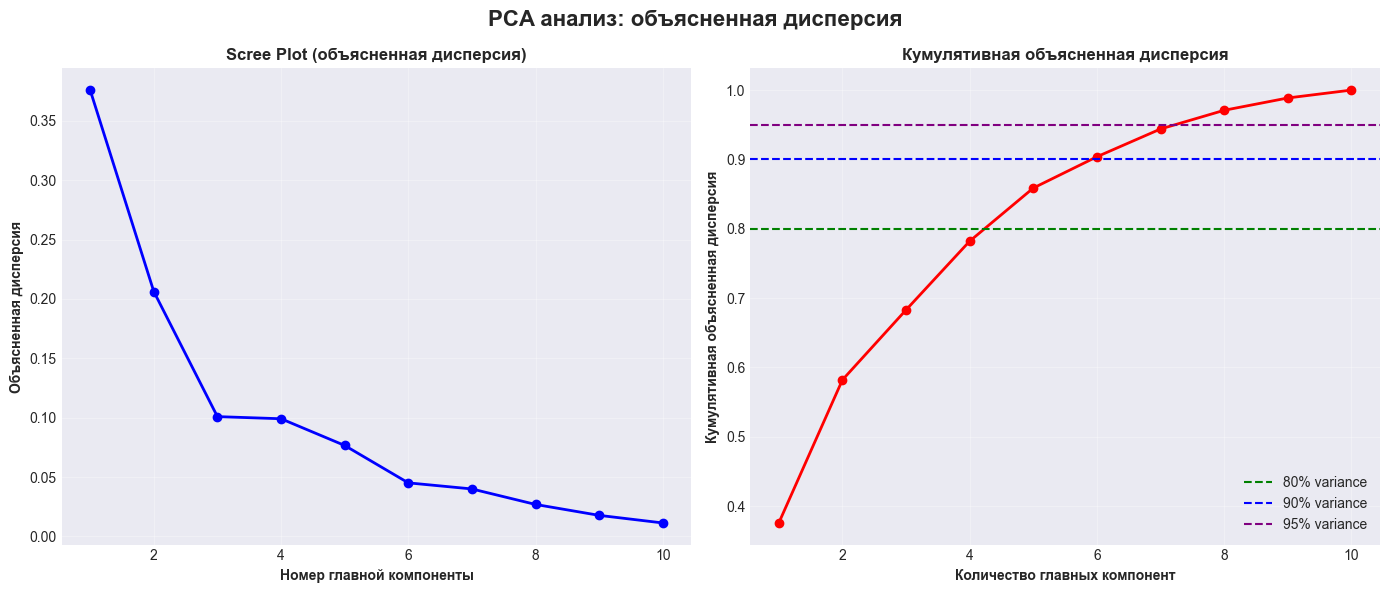


Для объяснения 80% дисперсии нужно 5 компонент
Для объяснения 90% дисперсии нужно 6 компонент
Для объяснения 95% дисперсии нужно 8 компонент

7.3 Анализ нагрузок на главные компоненты...

Топ-10 переменных с наибольшими нагрузками на PC1:
video_download_count    0.463144
video_share_count       0.456678
video_comment_count     0.412714
Unnamed: 12             0.402507
Unnamed: 13             0.328494
video_like_count        0.279289
#                       0.198403
video_view_count        0.139003
video_duration_sec      0.000884
video_id                0.000328
Name: PC1, dtype: float64

Топ-10 переменных с наибольшими нагрузками на PC2:
video_view_count        0.568945
#                       0.504862
video_like_count        0.462874
Unnamed: 13             0.293385
video_download_count    0.207870
Unnamed: 12             0.193276
video_comment_count     0.183165
video_share_count       0.082169
video_duration_sec      0.014850
video_id                0.000622
Name: PC2, dtype: floa

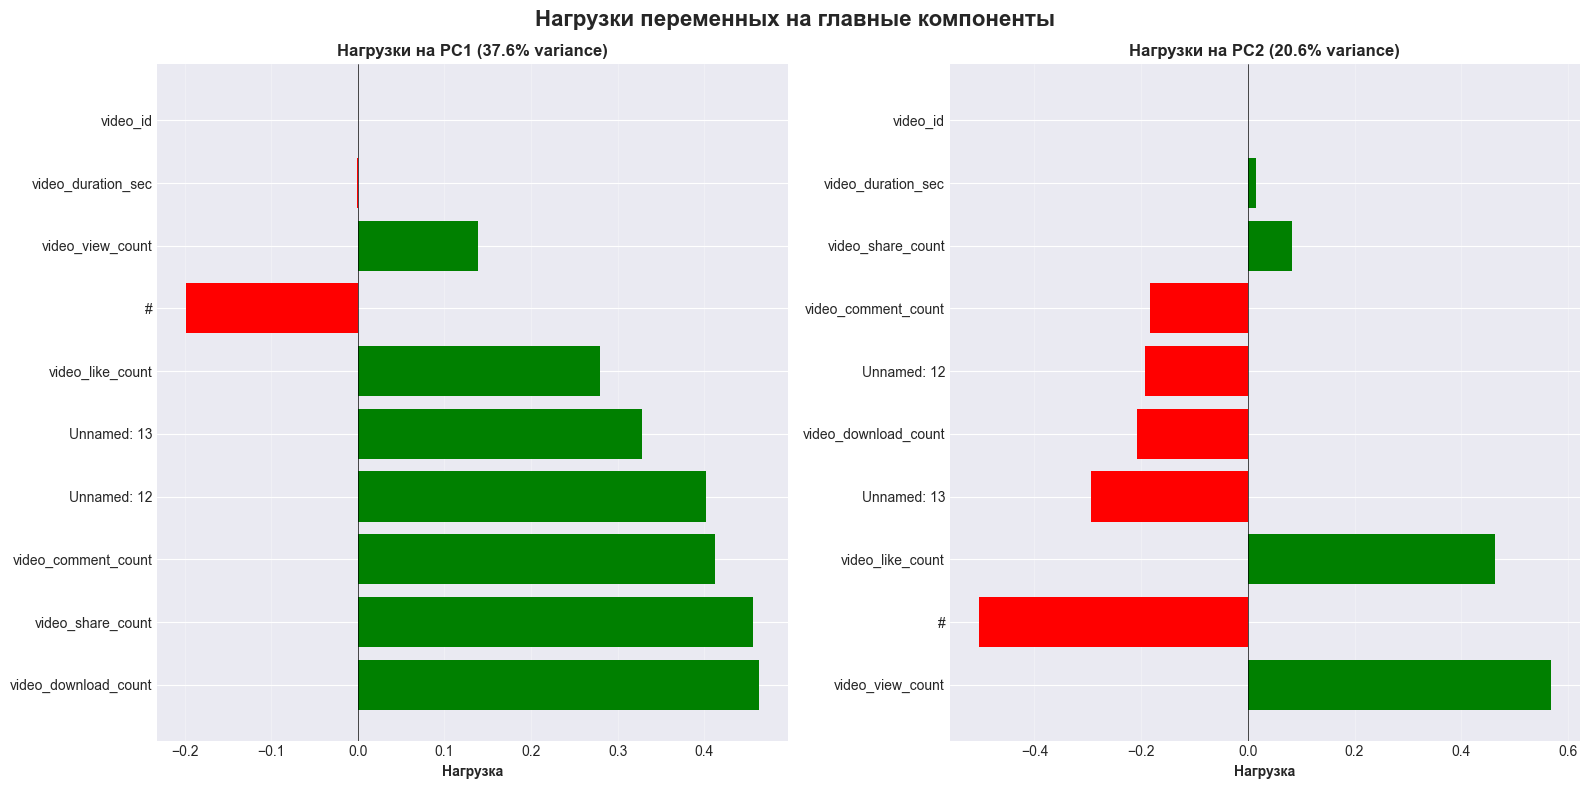


7.4 Biplot визуализация...


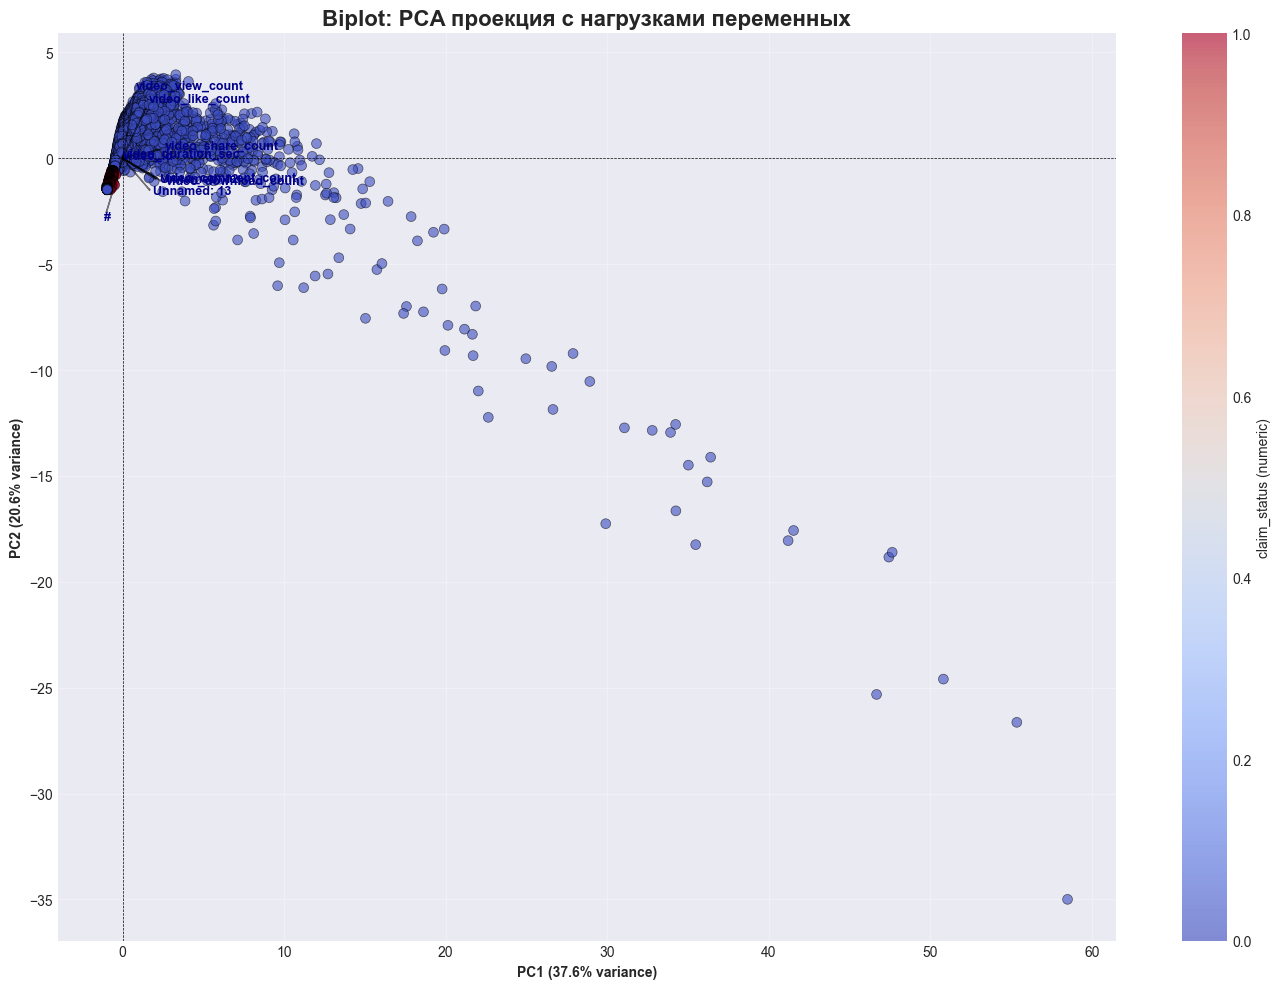

PCA анализ завершен!


In [39]:
# 7. СНИЖЕНИЕ РАЗМЕРНОСТИ И ВИЗУАЛИЗАЦИЯ
print("\n" + "=" * 80)
print("7. PCA АНАЛИЗ И СНИЖЕНИЕ РАЗМЕРНОСТИ")
print("=" * 80)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 7.1 Полный PCA анализ
print("\n7.1 PCA анализ всех числовых переменных...")

# Используем все числовые переменные для PCA
all_numeric_vars = continuous_vars + ordinal_vars

# Фильтруем только существующие и числовые переменные
valid_numeric_vars = []
for var in all_numeric_vars:
    if var in df.columns and pd.api.types.is_numeric_dtype(df[var]):
        # Проверяем, что нет слишком много пропусков
        if df[var].isnull().sum() / len(df) < 0.5:  # Меньше 50% пропусков
            valid_numeric_vars.append(var)

print(f"Используем {len(valid_numeric_vars)} числовых переменных для PCA")

if len(valid_numeric_vars) < 2:
    print("ВНИМАНИЕ: Недостаточно переменных для PCA анализа! Нужно минимум 2.")
else:
    X_pca_full = df[valid_numeric_vars].copy()
    
    # Удаляем строки с пропусками
    X_pca_full = X_pca_full.dropna()
    print(f"Размер данных после удаления пропусков: {X_pca_full.shape}")
    
    if len(X_pca_full) < 2:
        print("ВНИМАНИЕ: Недостаточно данных для PCA анализа!")
    else:
        # Масштабирование
        scaler_pca = StandardScaler()
        X_pca_scaled = scaler_pca.fit_transform(X_pca_full)
        
        # PCA со всеми компонентами
        pca_full = PCA()
        X_pca_transformed = pca_full.fit_transform(X_pca_scaled)
        
        # Анализ объясненной дисперсии
        explained_variance = pca_full.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance)
        
        print(f"Создано {len(explained_variance)} главных компонент")
                # 7.2 Визуализация объясненной дисперсии
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # Scree plot
        axes[0].plot(range(1, len(explained_variance) + 1), explained_variance, 'bo-', linewidth=2)
        axes[0].set_xlabel('Номер главной компоненты', fontweight='bold')
        axes[0].set_ylabel('Объясненная дисперсия', fontweight='bold')
        axes[0].set_title('Scree Plot (объясненная дисперсия)', fontweight='bold')
        axes[0].grid(True, alpha=0.3)
        
        # Кумулятивная дисперсия
        axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'ro-', linewidth=2)
        axes[1].axhline(y=0.8, color='g', linestyle='--', label='80% variance')
        axes[1].axhline(y=0.9, color='b', linestyle='--', label='90% variance')
        axes[1].axhline(y=0.95, color='purple', linestyle='--', label='95% variance')
        axes[1].set_xlabel('Количество главных компонент', fontweight='bold')
        axes[1].set_ylabel('Кумулятивная объясненная дисперсия', fontweight='bold')
        axes[1].set_title('Кумулятивная объясненная дисперсия', fontweight='bold')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.suptitle('PCA анализ: объясненная дисперсия', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('pca_variance_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Определение числа компонент для 80%, 90%, 95% дисперсии
        n_components_80 = np.where(cumulative_variance >= 0.8)[0]
        n_components_90 = np.where(cumulative_variance >= 0.9)[0]
        n_components_95 = np.where(cumulative_variance >= 0.95)[0]
        
        if len(n_components_80) > 0:
            n_comp_80 = n_components_80[0] + 1
            print(f"\nДля объяснения 80% дисперсии нужно {n_comp_80} компонент")
        else:
            print(f"\nДля объяснения 80% дисперсии нужно более {len(explained_variance)} компонент")
        
        if len(n_components_90) > 0:
            n_comp_90 = n_components_90[0] + 1
            print(f"Для объяснения 90% дисперсии нужно {n_comp_90} компонент")
        else:
            print(f"Для объяснения 90% дисперсии нужно более {len(explained_variance)} компонент")
        
        if len(n_components_95) > 0:
            n_comp_95 = n_components_95[0] + 1
            print(f"Для объяснения 95% дисперсии нужно {n_comp_95} компонент")
        else:
            print(f"Для объяснения 95% дисперсии нужно более {len(explained_variance)} компонент")
                    # 7.3 Анализ нагрузок на первые две компоненты
        print("\n7.3 Анализ нагрузок на главные компоненты...")
        
        # Создаем DataFrame с нагрузками
        loadings = pd.DataFrame(
            pca_full.components_[:2].T,
            columns=['PC1', 'PC2'],
            index=valid_numeric_vars
        )
        
        # Сортируем по абсолютной величине нагрузок
        print("\nТоп-10 переменных с наибольшими нагрузками на PC1:")
        print(loadings['PC1'].abs().sort_values(ascending=False).head(10))
        
        print("\nТоп-10 переменных с наибольшими нагрузками на PC2:")
        print(loadings['PC2'].abs().sort_values(ascending=False).head(10))
        
        # Визуализация нагрузок
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        
        # Нагрузки на PC1
        top_pc1 = loadings['PC1'].abs().sort_values(ascending=False).head(15)
        colors_pc1 = ['red' if x < 0 else 'green' for x in loadings.loc[top_pc1.index, 'PC1']]
        axes[0].barh(range(len(top_pc1)), loadings.loc[top_pc1.index, 'PC1'], color=colors_pc1)
        axes[0].set_yticks(range(len(top_pc1)))
        axes[0].set_yticklabels(top_pc1.index)
        axes[0].set_xlabel('Нагрузка', fontweight='bold')
        axes[0].set_title(f'Нагрузки на PC1 ({explained_variance[0]*100:.1f}% variance)', fontweight='bold')
        axes[0].axvline(x=0, color='black', linewidth=0.5)
        axes[0].grid(axis='x', alpha=0.3)
        
        # Нагрузки на PC2
        top_pc2 = loadings['PC2'].abs().sort_values(ascending=False).head(15)
        colors_pc2 = ['red' if x < 0 else 'green' for x in loadings.loc[top_pc2.index, 'PC2']]
        axes[1].barh(range(len(top_pc2)), loadings.loc[top_pc2.index, 'PC2'], color=colors_pc2)
        axes[1].set_yticks(range(len(top_pc2)))
        axes[1].set_yticklabels(top_pc2.index)
        axes[1].set_xlabel('Нагрузка', fontweight='bold')
        axes[1].set_title(f'Нагрузки на PC2 ({explained_variance[1]*100:.1f}% variance)', fontweight='bold')
        axes[1].axvline(x=0, color='black', linewidth=0.5)
        axes[1].grid(axis='x', alpha=0.3)
        
        plt.suptitle('Нагрузки переменных на главные компоненты', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig('pca_loadings_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        # 7.4 Biplot (комбинированная визуализация)
        print("\n7.4 Biplot визуализация...")
        
        # Создаем biplot
        plt.figure(figsize=(14, 10))
        
        # Определяем цветовую схему для точек
        if target_candidates and 'target_var_numeric' in locals() and target_var_numeric and target_var_numeric in df_numeric.columns:
            # Используем целевую переменную для раскраски
            # Берем только строки, которые есть в X_pca_full
            target_values_for_plot = df_numeric.loc[X_pca_full.index, target_var_numeric]
            scatter = plt.scatter(X_pca_transformed[:, 0], X_pca_transformed[:, 1], 
                                 c=target_values_for_plot, cmap='coolwarm', 
                                 alpha=0.6, s=50, edgecolor='k', linewidth=0.5)
            plt.colorbar(scatter, label=f'{target_var} (numeric)')
        elif 'Cluster' in df.columns:
            # Используем кластеры для раскраски, если они есть
            cluster_values_for_plot = df.loc[X_pca_full.index, 'Cluster']
            cluster_values_for_plot = cluster_values_for_plot.dropna()
            if len(cluster_values_for_plot) > 0:
                # Берем только строки с кластерами
                mask = cluster_values_for_plot.notna()
                scatter = plt.scatter(X_pca_transformed[mask, 0], X_pca_transformed[mask, 1], 
                                     c=cluster_values_for_plot[mask], cmap='tab10', 
                                     alpha=0.6, s=50, edgecolor='k', linewidth=0.5)
                plt.colorbar(scatter, label='Cluster')
            else:
                scatter = plt.scatter(X_pca_transformed[:, 0], X_pca_transformed[:, 1], 
                                     alpha=0.6, s=50, edgecolor='k', linewidth=0.5, color='blue')
        else:
            # Без раскраски
            scatter = plt.scatter(X_pca_transformed[:, 0], X_pca_transformed[:, 1], 
                                 alpha=0.6, s=50, edgecolor='k', linewidth=0.5, color='blue')
        
        # Векторы нагрузок (показываем только топ-10 для читаемости)
        scale_factor = 5  # Масштаб для векторов
        top_features = loadings['PC1'].abs().sort_values(ascending=False).head(10).index
        
        for feature in top_features:
            plt.arrow(0, 0, loadings.loc[feature, 'PC1'] * scale_factor, 
                      loadings.loc[feature, 'PC2'] * scale_factor,
                      color='black', alpha=0.5, head_width=0.05)
            plt.text(loadings.loc[feature, 'PC1'] * scale_factor * 1.15,
                     loadings.loc[feature, 'PC2'] * scale_factor * 1.15,
                     feature, color='darkblue', fontsize=9, fontweight='bold')
        
        plt.xlabel(f'PC1 ({explained_variance[0]*100:.1f}% variance)', fontweight='bold')
        plt.ylabel(f'PC2 ({explained_variance[1]*100:.1f}% variance)', fontweight='bold')
        plt.title('Biplot: PCA проекция с нагрузками переменных', fontsize=16, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)
        plt.axvline(x=0, color='k', linestyle='--', linewidth=0.5)
        
        plt.tight_layout()
        plt.savefig('pca_biplot.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print("PCA анализ завершен!")

## 8. ПОСТРОЕНИЕ ПРОГНОЗИРУЮЩЕЙ МОДЕЛИ


In [40]:
# 8. ПОСТРОЕНИЕ ПРОГНОЗИРУЮЩЕЙ МОДЕЛИ
print("\n" + "=" * 80)
print("8. ПОСТРОЕНИЕ ПРОГНОЗИРУЮЩЕЙ МОДЕЛИ")
print("=" * 80)

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_curve, auc, roc_auc_score, precision_recall_curve,
                           f1_score, precision_score, recall_score)

# Проверка данных перед моделированием
print("\n" + "=" * 80)
print("ПРОВЕРКА ДАННЫХ ПЕРЕД МОДЕЛИРОВАНИЕМ")
print("=" * 80)

# Проверяем наличие переменной df
if 'df' not in locals() or df is None:
    print("ОШИБКА: Переменная df не определена!")
    print("Пожалуйста, выполните предыдущие ячейки для загрузки данных.")
else:
    print(f"Общий размер датасета: {df.shape}")
    print(f"Количество строк: {df.shape[0]}")
    print(f"Количество столбцов: {df.shape[1]}")

# Проверяем целевую переменную (используем автоматически найденную)
if target_candidates and len(target_candidates) > 0:
    target_var = target_candidates[0]
    print(f"\nАнализ целевой переменной {target_var}:")
    print(f"  Тип данных: {df[target_var].dtype}")
    print(f"  Уникальные значения: {df[target_var].unique()}")
    
    # Подсчет распределения
    target_counts = df[target_var].value_counts()
    for val, count in target_counts.items():
        percentage = count / len(df) * 100
        print(f"  '{val}': {count} ({percentage:.1f}%)")
    
    # Проверяем на NaN
    nan_count = df[target_var].isna().sum()
    if nan_count > 0:
        print(f"  ВНИМАНИЕ: Найдено {nan_count} NaN значений в {target_var}!")
        
        # Заполняем наиболее частым значением
        mode_val = df[target_var].mode()[0] if not df[target_var].mode().empty else df[target_var].value_counts().index[0]
        print(f"  Заполняем NaN значением '{mode_val}'...")
        df[target_var].fillna(mode_val, inplace=True)
    
    # Приводим к стандартному виду (если строковая)
    if df[target_var].dtype == 'object':
        print("  Приводим к стандартному виду...")
        df[target_var] = df[target_var].astype(str).str.strip().str.title()
else:
    print("\nВНИМАНИЕ: Целевая переменная не найдена автоматически!")
    print("Для построения модели нужна целевая переменная.")
    target_var = None

print("\nПроверка числовых признаков на проблемы:")
numeric_cols = df.select_dtypes(include=[np.number]).columns
problem_cols = []

for col in numeric_cols:
    nan_count = df[col].isna().sum()
    inf_count = np.isinf(df[col]).sum()
    
    if nan_count > 0 or inf_count > 0:
        problem_cols.append((col, nan_count, inf_count))

if len(problem_cols) > 0:
    print(f"  Найдено {len(problem_cols)} проблемных колонок:")
    for col, nan_count, inf_count in problem_cols[:10]:  # Показываем первые 10
        print(f"    {col}: {nan_count} NaN, {inf_count} inf/-inf")
    
    print("\n  Исправление проблемных колонок...")
    for col in numeric_cols:
        # Заменяем inf на NaN
        df[col] = df[col].replace([np.inf, -np.inf], np.nan)
        
        # Заполняем NaN медианой
        if df[col].isna().sum() > 0:
            median_val = df[col].median()
            if pd.notna(median_val):
                df[col].fillna(median_val, inplace=True)
            else:
                df[col].fillna(0, inplace=True)
    
    print("  Проблемы исправлены!")
else:
    print("  Проблемных колонок не найдено")

print("\nПроверка категориальных признаков:")
categorical_cols_check = df.select_dtypes(include=['object']).columns
if len(categorical_cols_check) > 0:
    print(f"  Найдено {len(categorical_cols_check)} категориальных колонок:")
    for col in categorical_cols_check[:5]:  # Показываем первые 5
        print(f"    {col}: {df[col].dtype}, уникальных значений: {df[col].nunique()}")
else:
    print("  Категориальных колонок не найдено")



8. ПОСТРОЕНИЕ ПРОГНОЗИРУЮЩЕЙ МОДЕЛИ

ПРОВЕРКА ДАННЫХ ПЕРЕД МОДЕЛИРОВАНИЕМ
Общий размер датасета: (19382, 15)
Количество строк: 19382
Количество столбцов: 15

Анализ целевой переменной claim_status:
  Тип данных: object
  Уникальные значения: ['claim' 'opinion']
  'claim': 9906 (51.1%)
  'opinion': 9476 (48.9%)
  Приводим к стандартному виду...

Проверка числовых признаков на проблемы:
  Проблемных колонок не найдено

Проверка категориальных признаков:
  Найдено 4 категориальных колонок:
    claim_status: object, уникальных значений: 2
    video_transcription_text: object, уникальных значений: 19012
    verified_status: object, уникальных значений: 28
    author_ban_status: object, уникальных значений: 8


In [41]:
# 8.1 Подготовка данных для моделирования
if target_var and target_var in df.columns:
    print("\n8.1 Подготовка данных для моделирования...")
    
    # Создаем бинарную целевую переменную
    print(f"Преобразование целевой переменной {target_var}...")
    print(f"Уникальные значения {target_var}: {df[target_var].unique()}")
    
    # Приводим к стандартному виду (если строковая)
    if df[target_var].dtype == 'object':
        df[target_var] = df[target_var].astype(str).str.strip().str.title()
    
    # Создаем бинарную целевую переменную
    # Определяем уникальные значения
    unique_vals = df[target_var].dropna().unique()
    
    if len(unique_vals) == 2:
        # Бинарная переменная - создаем маппинг
        sorted_vals = sorted([str(v) for v in unique_vals])
        target_map = {sorted_vals[0]: 0, sorted_vals[1]: 1}
        # Также добавляем варианты написания
        for val in unique_vals:
            val_str = str(val).strip().title()
            if val_str not in target_map:
                # Определяем к какому классу отнести
                if any(keyword in val_str.lower() for keyword in ['yes', '1', 'true', 'positive']):
                    target_map[val_str] = 1
                else:
                    target_map[val_str] = 0
        
        y = df[target_var].astype(str).map(target_map)
    elif len(unique_vals) > 2:
        # Многоклассовая - берем два самых частых класса
        print(f"  ВНИМАНИЕ: {target_var} имеет {len(unique_vals)} классов. Берем два самых частых.")
        value_counts = df[target_var].value_counts()
        top_two = value_counts.head(2).index.tolist()
        target_map = {str(top_two[0]): 0, str(top_two[1]): 1}
        # Остальные относим к классу 0
        for val in unique_vals:
            if str(val) not in target_map:
                target_map[str(val)] = 0
        y = df[target_var].astype(str).map(target_map)
    else:
        # Если числовая, проверяем бинарность
        if pd.api.types.is_numeric_dtype(df[target_var]):
            unique_numeric = df[target_var].dropna().unique()
            if len(unique_numeric) == 2:
                # Уже бинарная числовая
                y = df[target_var].copy()
            else:
                # Преобразуем в бинарную (медиана как порог)
                median_val = df[target_var].median()
                y = (df[target_var] > median_val).astype(int)
                print(f"  Преобразуем в бинарную используя медиану ({median_val}) как порог")
        else:
            print(f"  ОШИБКА: Не удалось преобразовать {target_var} в бинарную переменную")
            y = None
    
    if y is not None:
        # Проверяем результат
        print(f"\nРаспределение целевой переменной:")
        print(f"  Всего записей: {len(y)}")
        print(f"  Класс 1: {(y == 1).sum()} ({(y == 1).mean()*100:.1f}%)")
        print(f"  Класс 0: {(y == 0).sum()} ({(y == 0).mean()*100:.1f}%)")
        print(f"  NaN значений: {y.isna().sum()}")
        
        # Удаляем строки с NaN в целевой переменной
        if y.isna().sum() > 0:
            print(f"\nУдаляем {y.isna().sum()} строк с NaN в целевой переменной...")
            valid_indices = y.dropna().index
            df = df.loc[valid_indices].copy()
            y = y.loc[valid_indices].copy()
            
            print(f"  Осталось записей: {len(y)}")
            print(f"  Класс 1: {(y == 1).sum()} ({(y == 1).mean()*100:.1f}%)")
            print(f"  Класс 0: {(y == 0).sum()} ({(y == 0).mean()*100:.1f}%)")
        
        # Проверяем баланс классов
        if (y == 1).sum() < 2 or (y == 0).sum() < 2:
            print("\nВНИМАНИЕ: Слишком мало примеров одного из классов для моделирования!")
            y = None
else:
    print("\n8.1 Пропускаем подготовку данных: целевая переменная не найдена")
    y = None



8.1 Подготовка данных для моделирования...
Преобразование целевой переменной claim_status...
Уникальные значения claim_status: ['Claim' 'Opinion']

Распределение целевой переменной:
  Всего записей: 19382
  Класс 1: 9476 (48.9%)
  Класс 0: 9906 (51.1%)
  NaN значений: 0


In [42]:
# Подготовка признаков
if y is not None and target_var:
    print("\nПодготовка матрицы признаков...")
    
    # Список колонок для исключения
    cols_to_drop = [target_var, 'Cluster']
    if 'target_var_numeric' in locals() and target_var_numeric and target_var_numeric in df.columns:
        cols_to_drop.append(target_var_numeric)
    
    X = df.drop(cols_to_drop, axis=1, errors='ignore')
    
    # Проверяем наличие нечисловых колонок
    non_numeric_cols = X.select_dtypes(exclude=[np.number]).columns
    if len(non_numeric_cols) > 0:
        print(f"Найдены нечисловые колонки ({len(non_numeric_cols)}): {list(non_numeric_cols)[:10]}")
        X = pd.get_dummies(X, drop_first=True)
        print(f"После one-hot encoding: {X.shape[1]} признаков")
    else:
        print("Все колонки уже числовые")
    
    print(f"\nРазмер матрицы признаков: {X.shape}")
    print(f"Баланс классов: {y.value_counts().to_dict()}")
    
    # Проверяем на NaN в признаках
    nan_in_X = X.isna().sum().sum()
    if nan_in_X > 0:
        print(f"\nПредупреждение: в матрице признаков найдено {nan_in_X} NaN значений")
        print("Заполняем NaN медианами по столбцам...")
        for col in X.columns:
            if X[col].isna().sum() > 0:
                median_val = X[col].median()
                if pd.notna(median_val):
                    X[col].fillna(median_val, inplace=True)
                else:
                    X[col].fillna(0, inplace=True)
    
    # Убеждаемся, что все колонки числовые перед проверкой на inf
    # Конвертируем все колонки в числовой тип (после one-hot encoding они должны быть числовыми)
    for col in X.columns:
        X[col] = pd.to_numeric(X[col], errors='coerce')
    
    # Проверяем на бесконечные значения (только для числовых колонок)
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        inf_in_X = np.isinf(X[numeric_cols].values).sum()
        if inf_in_X > 0:
            print(f"\nПредупреждение: в матрице признаков найдено {inf_in_X} inf/-inf значений")
            print("Заменяем inf/-inf на NaN, затем заполняем медианами...")
            X = X.replace([np.inf, -np.inf], np.nan)
            for col in X.columns:
                if X[col].isna().sum() > 0:
                    median_val = X[col].median()
                    if pd.notna(median_val):
                        X[col].fillna(median_val, inplace=True)
                    else:
                        X[col].fillna(0, inplace=True)
    else:
        print("\nПредупреждение: не найдено числовых колонок для проверки на inf")
    
    # Разделение данных
    print("\nРазделение данных на тренировочную и тестовую выборки...")
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42, stratify=y
        )
        
        print(f"Размер тренировочной выборки: {X_train.shape}")
        print(f"Размер тестовой выборки: {X_test.shape}")
        print(f"Класс 1 в тренировочной выборке: {y_train.mean():.3f} ({y_train.sum()}/{len(y_train)})")
        print(f"Класс 1 в тестовой выборке: {y_test.mean():.3f} ({y_test.sum()}/{len(y_test)})")
        
    except ValueError as e:
        print(f"Ошибка при разделении данных: {e}")
        print("Пробуем разделение без stratify...")
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
        )
        
        print(f"Размер тренировочной выборки: {X_train.shape}")
        print(f"Размер тестовой выборки: {X_test.shape}")
        print(f"Класс 1 в тренировочной выборке: {y_train.mean():.3f} ({y_train.sum()}/{len(y_train)})")
        print(f"Класс 1 в тестовой выборке: {y_test.mean():.3f} ({y_test.sum()}/{len(y_test)})")
else:
    print("\nПропускаем подготовку признаков: целевая переменная не найдена или невалидна")
    X_train, X_test, y_train, y_test = None, None, None, None



Подготовка матрицы признаков...
Найдены нечисловые колонки (3): ['video_transcription_text', 'verified_status', 'author_ban_status']
После one-hot encoding: 19055 признаков

Размер матрицы признаков: (19382, 19055)
Баланс классов: {0: 9906, 1: 9476}

Разделение данных на тренировочную и тестовую выборки...
Размер тренировочной выборки: (13567, 19055)
Размер тестовой выборки: (5815, 19055)
Класс 1 в тренировочной выборке: 0.489 (6633/13567)
Класс 1 в тестовой выборке: 0.489 (2843/5815)


In [ ]:
# 8.2 Обучение и сравнение нескольких моделей
if X_train is not None and y_train is not None:
    print("\n8.2 Обучение и сравнение моделей...")
    
    # Определяем модели
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced_subsample', n_estimators=100),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
        'SVM': SVC(probability=True, random_state=42, class_weight='balanced', max_iter=1000)
    }
    
    # Результаты
    results = {}
    
    for name, model in models.items():
        print(f"\n--- {name} ---")
        
        try:
            # Кросс-валидация
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
            print(f"ROC-AUC (кросс-валидация): {cv_scores.mean():.3f} (+/- {cv_scores.std()*2:.3f})")
            
            # Обучение на всей тренировочной выборке
            model.fit(X_train, y_train)
            
            # Прогнозы
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
            
            # Метрики
            accuracy = np.mean(y_pred == y_test)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            
            roc_auc = None
            if y_pred_proba is not None:
                roc_auc = roc_auc_score(y_test, y_pred_proba)
                print(f"ROC-AUC (тест): {roc_auc:.3f}")
            
            print(f"Accuracy: {accuracy:.3f}")
            print(f"Precision: {precision:.3f}")
            print(f"Recall: {recall:.3f}")
            print(f"F1-Score: {f1:.3f}")
            
            # Сохранение результатов
            results[name] = {
                'model': model,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba,
                'cv_score': cv_scores.mean(),
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'roc_auc': roc_auc
            }
        except Exception as e:
            print(f"Ошибка при обучении {name}: {str(e)}")
            continue
    
    if len(results) == 0:
        print("\nВНИМАНИЕ: Не удалось обучить ни одной модели!")
    else:
        print(f"\nУспешно обучено {len(results)} моделей")
else:
    print("\n8.2 Пропускаем обучение моделей: данные не подготовлены")
    results = {}


In [ ]:
# 8.3 Визуализация результатов моделей
if len(results) > 0 and X_test is not None and y_test is not None:
    print("\n8.3 Визуализация результатов моделей...")
    
    # Создаем фигуру для визуализации
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 8.3.1 Сравнение метрик моделей
    metrics_comparison = pd.DataFrame({
        'Model': list(results.keys()),
        'ROC-AUC': [results[m]['roc_auc'] if results[m]['roc_auc'] is not None else 0 for m in results],
        'Accuracy': [results[m]['accuracy'] for m in results],
        'Precision': [results[m]['precision'] for m in results],
        'Recall': [results[m]['recall'] for m in results],
        'F1-Score': [results[m]['f1'] for m in results]
    }).set_index('Model')
    
    # Heatmap сравнения метрик
    sns.heatmap(metrics_comparison, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[0, 0])
    axes[0, 0].set_title('Сравнение метрик моделей', fontweight='bold')
    
    # 8.3.2 ROC-кривые
    axes[0, 1].plot([0, 1], [0, 1], 'k--', label='Случайная модель')
    for name, result in results.items():
        if result['y_pred_proba'] is not None:
            fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
            roc_auc = auc(fpr, tpr)
            axes[0, 1].plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)
    
    axes[0, 1].set_xlim([0.0, 1.0])
    axes[0, 1].set_ylim([0.0, 1.05])
    axes[0, 1].set_xlabel('False Positive Rate', fontweight='bold')
    axes[0, 1].set_ylabel('True Positive Rate', fontweight='bold')
    axes[0, 1].set_title('ROC-кривые моделей', fontweight='bold')
    axes[0, 1].legend(loc="lower right")
    axes[0, 1].grid(True, alpha=0.3)
    
    # 8.3.3 Precision-Recall кривые
    for name, result in results.items():
        if result['y_pred_proba'] is not None:
            precision_vals, recall_vals, _ = precision_recall_curve(y_test, result['y_pred_proba'])
            axes[0, 2].plot(recall_vals, precision_vals, label=name, linewidth=2)
    
    axes[0, 2].set_xlabel('Recall', fontweight='bold')
    axes[0, 2].set_ylabel('Precision', fontweight='bold')
    axes[0, 2].set_title('Precision-Recall кривые', fontweight='bold')
    axes[0, 2].legend(loc="upper right")
    axes[0, 2].grid(True, alpha=0.3)
    
    # 8.3.4 Матрицы ошибок для лучшей модели по F1-Score
    best_model_name = max(results.items(), key=lambda x: x[1]['f1'])[0]
    best_result = results[best_model_name]
    
    cm = confusion_matrix(y_test, best_result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
    axes[1, 0].set_xlabel('Предсказанный класс', fontweight='bold')
    axes[1, 0].set_ylabel('Истинный класс', fontweight='bold')
    axes[1, 0].set_title(f'Матрица ошибок: {best_model_name}\nF1-Score: {best_result["f1"]:.3f}', fontweight='bold')
    
    # 8.3.5 Важность признаков для tree-based моделей
    if best_model_name in ['Random Forest', 'Gradient Boosting']:
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': best_result['model'].feature_importances_
        }).sort_values('importance', ascending=False).head(15)
        
        axes[1, 1].barh(range(len(feature_importance)), 
                        feature_importance['importance'].values,
                        color='skyblue')
        axes[1, 1].set_yticks(range(len(feature_importance)))
        axes[1, 1].set_yticklabels(feature_importance['feature'])
        axes[1, 1].set_xlabel('Важность', fontweight='bold')
        axes[1, 1].set_title(f'Топ-15 важных признаков: {best_model_name}', fontweight='bold')
        axes[1, 1].invert_yaxis()
    else:
        # Для логистической регрессии - коэффициенты
        if best_model_name == 'Logistic Regression':
            coef_df = pd.DataFrame({
                'feature': X.columns,
                'coefficient': best_result['model'].coef_[0]
            }).sort_values('coefficient', key=abs, ascending=False).head(15)
            
            colors = ['red' if x < 0 else 'green' for x in coef_df['coefficient']]
            axes[1, 1].barh(range(len(coef_df)), coef_df['coefficient'].values, color=colors)
            axes[1, 1].set_yticks(range(len(coef_df)))
            axes[1, 1].set_yticklabels(coef_df['feature'])
            axes[1, 1].set_xlabel('Коэффициент', fontweight='bold')
            axes[1, 1].set_title(f'Топ-15 коэффициентов: {best_model_name}', fontweight='bold')
            axes[1, 1].invert_yaxis()
            axes[1, 1].axvline(x=0, color='black', linewidth=0.5)
        else:
            axes[1, 1].text(0.5, 0.5, 'Feature importance\nnot available\nfor this model',
                           ha='center', va='center', transform=axes[1, 1].transAxes,
                           fontsize=12)
            axes[1, 1].set_title('Важность признаков', fontweight='bold')
            axes[1, 1].axis('off')
    
    # 8.3.6 Сводная таблица лучшей модели
    roc_auc_val = best_result['roc_auc'] if best_result['roc_auc'] is not None else 0
    summary_text = f"""
Лучшая модель: {best_model_name}

Метрики:
- ROC-AUC: {roc_auc_val:.3f}
- Accuracy: {best_result['accuracy']:.3f}
- Precision: {best_result['precision']:.3f}
- Recall: {best_result['recall']:.3f}
- F1-Score: {best_result['f1']:.3f}

Кросс-валидация (ROC-AUC):
Среднее: {best_result['cv_score']:.3f}
"""
    axes[1, 2].text(0.1, 0.5, summary_text, transform=axes[1, 2].transAxes,
                    fontsize=10, verticalalignment='center',
                    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    axes[1, 2].axis('off')
    axes[1, 2].set_title('Сводка по лучшей модели', fontweight='bold')
    
    model_title = f'Результаты моделирования {target_var}' if target_var else 'Результаты моделирования'
    plt.suptitle(model_title, fontsize=18, fontweight='bold')
    plt.tight_layout()
    plt.savefig('model_results_summary.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Визуализация завершена!")
else:
    print("\n8.3 Пропускаем визуализацию: нет обученных моделей или данных")


## 9. СВОДНЫЙ АНАЛИЗ И ВЫВОДЫ


In [ ]:
# 9. СВОДНЫЙ АНАЛИЗ И ВЫВОДЫ
print("\n" + "=" * 80)
print("9. СВОДНЫЙ АНАЛИЗ И ВЫВОДЫ")
print("=" * 80)

# Пересчитываем ключевые статистики ПОСЛЕ всех изменений данных
print("\n9.1 КЛЮЧЕВЫЕ ВЫВОДЫ И РЕКОМЕНДАЦИИ\n")

# Пересчитываем статистики целевой переменной
print("1. БАЗОВАЯ СТАТИСТИКА:")

# Проверяем наличие необходимых переменных
if 'df' not in locals() or df is None:
    print("   • ОШИБКА: Переменная df не определена!")
    print("   • Пожалуйста, выполните предыдущие ячейки для загрузки данных.")
elif 'target_var' not in locals() or not target_var:
    print("   • Целевая переменная: не найдена")
    print("   • Пожалуйста, выполните предыдущие ячейки для определения целевой переменной.")
elif target_var and target_var in df.columns:
    # Текущая статистика после всех обработок
    current_target_counts = df[target_var].value_counts()
    current_target_percentage = df[target_var].value_counts(normalize=True) * 100
    
    # Проверяем формат целевой переменной (числовой или строковый)
    target_values = df[target_var].unique()
    
    # Определяем метки для классов
    if df[target_var].dtype == 'object':
        # Строковый формат - ищем положительный класс
        positive_labels = ['Yes', 'YES', 'yes', '1', 'True', 'true', 'Positive', 'positive']
        positive_label = None
        for label in positive_labels:
            if label in df[target_var].values:
                positive_label = label
                break
        if positive_label is None:
            # Берем первое значение как положительный класс
            positive_label = current_target_counts.index[0]
    else:
        # Числовой формат
        positive_label = 1
    
    # Получаем значения для положительного класса
    if positive_label in current_target_counts.index:
        target_positive = current_target_counts[positive_label]
        target_positive_pct = current_target_percentage[positive_label]
    else:
        # Если нет, ищем альтернативные обозначения
        target_positive = 0
        target_positive_pct = 0
        for val in current_target_counts.index:
            if str(val).lower() in ['yes', 'y', '1', 1, 'true', 'positive']:
                target_positive = current_target_counts[val]
                target_positive_pct = current_target_percentage[val]
                break
    
    print(f"   • Распределение целевой переменной {target_var}:")
    for val, count in current_target_counts.items():
        pct = current_target_percentage[val]
        print(f"     - {val}: {count} ({pct:.1f}%)")
    print(f"   • Положительный класс: {target_positive_pct:.1f}% ({target_positive} наблюдений)")
else:
    print("   • Целевая переменная: не найдена")
    target_positive = 0
    target_positive_pct = 0

print(f"   • Размер выборки: {len(df)} наблюдений")
print(f"   • Количество признаков: {df.shape[1]}")

print(f"\n2. КЛЮЧЕВЫЕ ФАКТОРЫ, ВЛИЯЮЩИЕ НА {target_var if target_var else 'ЦЕЛЕВУЮ ПЕРЕМЕННУЮ'}:")

# Факторы из корреляционного анализа
if 'target_corr' in locals() and target_corr is not None and len(target_corr) > 0:
    print("   А) Числовые переменные (наибольшая корреляция):")
    
    # Исключаем саму целевую переменную если она есть
    if target_var_numeric and target_var_numeric in target_corr.index:
        relevant_corr = target_corr.drop(target_var_numeric)
    else:
        relevant_corr = target_corr
    
    # Сортируем по абсолютному значению
    top_corr_abs = relevant_corr.abs().sort_values(ascending=False).head(5)
    
    for i, (var, corr_abs) in enumerate(top_corr_abs.items(), 1):
        # Получаем реальное значение корреляции
        corr_value = relevant_corr[var]
        direction = "увеличивает" if corr_value > 0 else "уменьшает"
        print(f"      {i}. {var}: {corr_value:.3f} ({direction} вероятность положительного класса)")
else:
    print("   А) Числовые переменные: данные корреляционного анализа недоступны")

# Бинарные переменные
if 'odds_df' in locals() and not odds_df.empty and len(odds_df) > 0:
    print("\n   Б) Бинарные переменные (наибольшее влияние):")
    top_binary = odds_df.head(3)
    
    for i, row in top_binary.iterrows():
        if 'odds_ratio' in row:
            if row['odds_ratio'] > 1:
                effect = "повышает"
                effect_text = f"в {row['odds_ratio']:.1f} раз"
            else:
                effect = "снижает"
                effect_text = f"в {1/row['odds_ratio']:.1f} раз"
            
            # Укорачиваем название переменной если оно слишком длинное
            var_name = row['variable']
            if len(var_name) > 30:
                var_name = var_name[:27] + "..."
            
            print(f"      {i+1}. {var_name}: OR={row['odds_ratio']:.2f} ({effect} вероятность {effect_text})")
else:
    print("\n   Б) Бинарные переменные: данные анализа odds ratios недоступны")

# Кластерный анализ
print("\n3. КЛАСТЕРНЫЙ АНАЛИЗ:")
if 'Cluster' in df.columns and 'optimal_k' in locals():
    print(f"   • Оптимальное число кластеров: {optimal_k}")
    print("   • Распределение целевой переменной по кластерам:")
    
    cluster_analysis = []
    for cluster in sorted(df['Cluster'].dropna().unique()):
        cluster_size = (df['Cluster'] == cluster).sum()
        
        # Рассчитываем долю положительного класса для кластера
        cluster_data = df[df['Cluster'] == cluster]
        if target_var and target_var in cluster_data.columns:
            # Определяем формат целевой переменной
            if cluster_data[target_var].dtype == 'object':
                # Ищем положительный класс
                positive_count = 0
                for val in cluster_data[target_var].dropna():
                    if str(val).lower() in ['yes', 'y', '1', 'true', 'positive']:
                        positive_count += 1
            else:
                # Числовой формат
                positive_count = (cluster_data[target_var] == 1).sum()
            
            positive_rate = (positive_count / cluster_size * 100) if cluster_size > 0 else 0
            cluster_analysis.append((cluster, cluster_size, positive_rate))
    
    # Сортируем по доле положительного класса (от высокой к низкой)
    cluster_analysis.sort(key=lambda x: x[2], reverse=True)
    
    for cluster, size, rate in cluster_analysis:
        print(f"      Кластер {cluster}: {size} наблюдений ({rate:.1f}% положительного класса)")
else:
    print("   • Кластерный анализ: не выполнен")

print("\n4. РЕЗУЛЬТАТЫ МОДЕЛИРОВАНИЯ:")
if 'best_model_name' in locals() and 'best_result' in locals():
    print(f"   • Лучшая модель: {best_model_name}")
    print(f"   • F1-Score: {best_result['f1']:.3f}")
    
    if best_result['roc_auc'] is not None:
        print(f"   • ROC-AUC: {best_result['roc_auc']:.3f}")
    else:
        print(f"   • ROC-AUC: не рассчитано")
    
    print(f"   • Accuracy: {best_result['accuracy']:.3f}")
    print(f"   • Precision: {best_result['precision']:.3f}")
    print(f"   • Recall: {best_result['recall']:.3f}")
else:
    print("   • Результаты моделирования: недоступны")


In [ ]:
# 9.2 Практические рекомендации
print("\n9.2 ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:\n")

print("1. ПРИОРИТЕТНЫЕ ГРУППЫ РИСКА:")
if target_var:
    print(f"   • Наблюдения с факторами, сильно коррелирующими с {target_var}")
    if 'top_corr_abs' in locals() and len(top_corr_abs) > 0:
        print(f"   • Особое внимание к переменным: {', '.join(top_corr_abs.head(3).index.tolist())}")
if 'Cluster' in df.columns:
    print(f"   • Кластер с наибольшей долей положительного класса (если анализ выполнен)")

print("\n2. МЕРЫ ПО УЛУЧШЕНИЮ:")
if target_var:
    print(f"   • Анализ и коррекция факторов из топ-корреляций с {target_var}")
    print("   • Регулярный мониторинг ключевых метрик")
    if 'odds_df' in locals() and not odds_df.empty:
        print("   • Фокус на бинарных переменных с высоким odds ratio")

print("\n3. МОНИТОРИНГ:")
print("   • Регулярный анализ ключевых метрик из данного отчета")
if 'Cluster' in df.columns:
    print("   • Фокус на наблюдениях из 'рисковых' кластеров")
print("   • A/B тестирование мер по улучшению")
if target_positive_pct > 0:
    print(f"   • Мониторинг доли положительного класса (текущее значение: {target_positive_pct:.1f}%)")


## 10. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ


In [ ]:
# 10. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
print("\n" + "=" * 80)
print("10. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ АНАЛИЗА")
print("=" * 80)

# Проверяем наличие необходимых переменных
if 'df' not in locals() or df is None:
    print("ОШИБКА: Переменная df не определена!")
    print("Пожалуйста, выполните предыдущие ячейки для загрузки данных.")
    print("Сохранение результатов пропущено.")
else:
    # Функция для расчета статистики целевой переменной
    def get_target_stats(df, target_var):
        if not target_var or target_var not in df.columns:
            return 0, 0, 0
        
        # Приводим к строковому формату
        target_series = df[target_var].astype(str).str.strip().str.title()
        
        # Определяем положительный класс
        positive_labels = ['Yes', 'YES', 'yes', '1', 'True', 'true', 'Positive', 'positive']
        positive_count = 0
        negative_count = 0
        
        for val in target_series.dropna():
            if str(val).lower() in [l.lower() for l in positive_labels]:
                positive_count += 1
            else:
                negative_count += 1
        
        total = positive_count + negative_count
        
        if total > 0:
            positive_pct = (positive_count / total) * 100
        else:
            positive_pct = 0
        
        return positive_count, positive_pct, total

# Получаем актуальные статистики
if target_var and target_var in df.columns:
    current_positive_count, current_positive_pct, current_total = get_target_stats(df, target_var)
else:
    current_positive_count, current_positive_pct, current_total = 0, 0, 0

# Определяем базовое имя для файлов
base_name = target_var.lower().replace(' ', '_') if target_var else 'analysis'

# Сохранение обработанных данных
processed_filename = f'{base_name}_processed.csv'
df.to_csv(processed_filename, index=False)
print(f"✓ Обработанные данные сохранены в: {processed_filename}")

# Сохранение ключевых метрик
summary_data = {
    'Метрика': [
        f'Положительный класс {target_var if target_var else "целевой переменной"} (%)',
        'Количество положительного класса',
        'Общее количество наблюдений',
        'Размер выборки (строки)',
        'Количество признаков (столбцы)',
        'Оптимальное число кластеров',
        'Лучшая модель',
        'F1-Score лучшей модели',
        'ROC-AUC лучшей модели',
        'Accuracy лучшей модели',
        'Precision лучшей модели',
        'Recall лучшей модели'
    ],
    'Значение': [
        current_positive_pct,
        int(current_positive_count),
        int(current_total),
        len(df),
        df.shape[1],
        optimal_k if 'optimal_k' in locals() else 'N/A',
        best_model_name if 'best_model_name' in locals() else 'N/A',
        best_result['f1'] if 'best_result' in locals() else 'N/A',
        best_result['roc_auc'] if 'best_result' in locals() and best_result['roc_auc'] is not None else 'N/A',
        best_result['accuracy'] if 'best_result' in locals() else 'N/A',
        best_result['precision'] if 'best_result' in locals() else 'N/A',
        best_result['recall'] if 'best_result' in locals() else 'N/A'
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_filename = f'{base_name}_summary.csv'
summary_df.to_csv(summary_filename, index=False)
print(f"✓ Сводные метрики сохранены в: {summary_filename}")

# Сохранение корреляций (если они есть)
if 'target_corr' in locals() and target_corr is not None and len(target_corr) > 0:
    try:
        target_corr_df = pd.DataFrame({
            'Признак': target_corr.index,
            f'Корреляция_с_{target_var if target_var else "целевой_переменной"}': target_corr.values
        })
        corr_filename = f'{base_name}_correlations.csv'
        target_corr_df.to_csv(corr_filename, index=False)
        print(f"✓ Корреляции сохранены в: {corr_filename}")
    except Exception as e:
        print(f"✗ Ошибка при сохранении корреляций: {e}")
else:
    print("✗ Корреляции не найдены для сохранения")

# Сохранение отношений шансов (если они есть)
if 'odds_df' in locals() and not odds_df.empty and len(odds_df) > 0:
    try:
        odds_filename = f'{base_name}_odds_ratios.csv'
        odds_df.to_csv(odds_filename, index=False)
        print(f"✓ Отношения шансов сохранены в: {odds_filename}")
    except Exception as e:
        print(f"✗ Ошибка при сохранении отношений шансов: {e}")
else:
    print("✗ Отношения шансов не найдены для сохранения")

# Сохранение профилей кластеров (если кластеризация выполнена)
if 'Cluster' in df.columns:
    try:
        # Создаем профили кластеров, если их еще нет
        if 'available_features' in locals() and len(available_features) > 0:
            df_clustered = df[df['Cluster'].notna()].copy()
            if len(df_clustered) > 0:
                cluster_profiles = df_clustered.groupby('Cluster')[available_features].mean()
                cluster_filename = f'{base_name}_cluster_profiles.csv'
                cluster_profiles.to_csv(cluster_filename)
                print(f"✓ Профили кластеров сохранены в: {cluster_filename}")
            else:
                print("✗ Профили кластеров не найдены для сохранения (нет данных с кластерами)")
        else:
            print("✗ Профили кластеров не найдены для сохранения")
    except Exception as e:
        print(f"✗ Ошибка при сохранении профилей кластеров: {e}")
else:
    print("✗ Профили кластеров не найдены для сохранения")

# Дополнительно: сохранение важных признаков из лучшей модели
if 'best_model_name' in locals() and 'best_result' in locals() and 'X' in locals():
    try:
        if best_model_name in ['Random Forest', 'Gradient Boosting']:
            feature_importance = pd.DataFrame({
                'feature': X.columns,
                'importance': best_result['model'].feature_importances_
            }).sort_values('importance', ascending=False)
            feature_filename = f'{base_name}_feature_importance.csv'
            feature_importance.to_csv(feature_filename, index=False)
            print(f"✓ Важность признаков сохранена в: {feature_filename}")
        elif best_model_name == 'Logistic Regression':
            coef_df = pd.DataFrame({
                'feature': X.columns,
                'coefficient': best_result['model'].coef_[0],
                'abs_coefficient': np.abs(best_result['model'].coef_[0])
            }).sort_values('abs_coefficient', ascending=False)
            coef_filename = f'{base_name}_logistic_coefficients.csv'
            coef_df.to_csv(coef_filename, index=False)
            print(f"✓ Коэффициенты логистической регрессии сохранены в: {coef_filename}")
    except Exception as e:
        print(f"✗ Ошибка при сохранении важности признаков: {e}")


In [ ]:
print("\n" + "=" * 80)
print("АНАЛИЗ УСПЕШНО ЗАВЕРШЕН!")
print("=" * 80)

print("\nСОЗДАННЫЕ ФАЙЛЫ:")
print("=" * 40)

import os
created_files = []

# Проверяем созданные файлы
file_checks = [
    # CSV файлы
    (f'{base_name}_processed.csv', 'Обработанные данные'),
    (f'{base_name}_summary.csv', 'Сводные метрики'),
    (f'{base_name}_correlations.csv', f'Корреляции с {target_var if target_var else "целевой переменной"}'),
    (f'{base_name}_odds_ratios.csv', 'Отношения шансов'),
    (f'{base_name}_cluster_profiles.csv', 'Профили кластеров'),
    (f'{base_name}_feature_importance.csv', 'Важность признаков'),
    (f'{base_name}_logistic_coefficients.csv', 'Коэффициенты регрессии'),
    # Графики
    ('class_balance.png', 'График: Баланс классов'),
    ('continuous_vars_distribution.png', 'График: Распределение числовых переменных'),
    ('ordinal_vars_distribution.png', 'График: Распределение порядковых переменных'),
    ('target_comparison_ttest.png', 'График: Сравнение по целевой переменной'),
    ('full_correlation_heatmap.png', 'График: Корреляционная матрица'),
    ('top_correlations_with_target.png', 'График: Топ корреляций'),
    ('odds_ratios_binary_vars.png', 'График: Odds Ratios'),
    ('categorical_vars_target.png', 'График: Категориальные переменные'),
    ('optimal_clusters_determination.png', 'График: Определение кластеров'),
    ('clustering_results.png', 'График: Результаты кластеризации'),
    ('cluster_profiles_heatmap.png', 'График: Профили кластеров'),
    ('pca_variance_analysis.png', 'График: PCA анализ'),
    ('pca_loadings_analysis.png', 'График: Нагрузки PCA'),
    ('pca_biplot.png', 'График: Biplot PCA'),
    ('model_results_summary.png', 'График: Результаты моделей'),
    ('final_analysis_dashboard.png', 'Дашборд: Итоговый дашборд'),
    ('missing_values_heatmap.png', 'График: Пропущенные значения'),
]

for filename, description in file_checks:
    if os.path.exists(filename):
        file_size = os.path.getsize(filename) / 1024  # Размер в КБ
        created_files.append((filename, description, file_size))
        print(f"✓ {description:45} [{filename}] ({file_size:.1f} KB)")
    else:
        print(f"✗ {description:45} [{filename}] (не создан)")

print("\n" + "=" * 40)
print(f"ИТОГО: {len(created_files)} файлов создано успешно")

if created_files:
    total_size = sum(f[2] for f in created_files)
    print(f"Общий размер: {total_size:.1f} KB")

print("\nКЛЮЧЕВЫЕ РЕЗУЛЬТАТЫ:")
print("=" * 40)

# Выводим ключевые результаты
if current_total > 0 and target_var:
    print(f"• Распределение {target_var}: {current_positive_pct:.1f}% положительного класса ({current_positive_count}/{current_total})")
elif target_var:
    print(f"• Целевая переменная {target_var}: данные недоступны")
else:
    print("• Целевая переменная: не найдена")

if 'optimal_k' in locals():
    print(f"• Оптимальное число кластеров: {optimal_k}")

if 'best_model_name' in locals() and 'best_result' in locals():
    print(f"• Лучшая модель предсказания: {best_model_name}")
    print(f"• Качество модели (F1-Score): {best_result['f1']:.3f}")

print("\nРЕКОМЕНДАЦИИ:")
print("=" * 40)
print(f"1. Проанализируйте файл {summary_filename} для основных метрик")
if 'target_corr' in locals() and target_corr is not None:
    print(f"2. Изучите {base_name}_correlations.csv для понимания факторов влияния")
if 'Cluster' in df.columns:
    print(f"3. Используйте {base_name}_cluster_profiles.csv для сегментации наблюдений")
print("4. Все графики сохранены в PNG файлах для презентаций и отчетов")
print(f"5. Обработанные данные в {processed_filename} можно использовать для дальнейшего анализа")

print("\n" + "=" * 80)
print("Анализ завершен! Результаты готовы для использования.")
print("=" * 80)


In [ ]:
# 9.3 Создание финального дашборда
print("\n" + "=" * 80)
print("СОЗДАНИЕ ФИНАЛЬНОГО ДАШБОРДА...")
print("=" * 80)

# Проверяем наличие необходимых данных
has_target = target_var and target_var in df.columns
has_corr = 'target_corr' in locals() and target_corr is not None and len(target_corr) > 0
has_cluster = 'Cluster' in df.columns
has_results = 'results' in locals() and len(results) > 0
has_best_model = 'best_model_name' in locals() and 'best_result' in locals()

if has_target or has_corr or has_cluster or has_results:
    # Создаем финальный дашборд
    fig = plt.figure(figsize=(20, 15))
    
    plot_idx = 0
    
    # 1. Распределение целевой переменной (левый верхний)
    if has_target:
        ax1 = plt.subplot2grid((4, 4), (0, 0), colspan=2)
        target_counts_plot = df[target_var].value_counts()
        if len(target_counts_plot) == 2:
            target_counts_plot.plot(kind='pie', ax=ax1, autopct='%1.1f%%', 
                                  colors=['#4CAF50', '#F44336'], startangle=90,
                                  explode=(0, 0.1), textprops={'fontsize': 12})
        else:
            target_counts_plot.plot(kind='pie', ax=ax1, autopct='%1.1f%%', 
                                  startangle=90, textprops={'fontsize': 12})
        ax1.set_ylabel('')
        ax1.set_title(f'Распределение {target_var}', fontsize=14, fontweight='bold')
        plot_idx += 1
    
    # 2. Топ корреляций (правый верхний)
    if has_corr:
        ax2 = plt.subplot2grid((4, 4), (0, 2), colspan=2)
        if target_var_numeric and target_var_numeric in target_corr.index:
            top_corr_plot = target_corr.drop(target_var_numeric).head(8)
        else:
            top_corr_plot = target_corr.head(8)
        
        if len(top_corr_plot) > 0:
            colors_corr = ['red' if x < 0 else 'green' for x in top_corr_plot.values]
            bars = ax2.barh(range(len(top_corr_plot)), top_corr_plot.values, color=colors_corr, alpha=0.7)
            ax2.set_yticks(range(len(top_corr_plot)))
            ax2.set_yticklabels(top_corr_plot.index, fontsize=10)
            ax2.set_xlabel(f'Корреляция с {target_var if target_var else "целевой переменной"}', fontweight='bold')
            ax2.set_title('Топ факторов влияния', fontsize=14, fontweight='bold')
            ax2.axvline(x=0, color='black', linewidth=0.5)
    
    # 3. Кластерный анализ (левый средний)
    if has_cluster:
        ax3 = plt.subplot2grid((4, 4), (1, 0), colspan=2)
        cluster_dist = df['Cluster'].dropna().value_counts().sort_index()
        cluster_target_rates = []
        
        for cluster in cluster_dist.index:
            cluster_data = df[df['Cluster'] == cluster]
            if has_target and target_var in cluster_data.columns:
                if cluster_data[target_var].dtype == 'object':
                    positive_count = sum(1 for val in cluster_data[target_var].dropna() 
                                       if str(val).lower() in ['yes', 'y', '1', 'true', 'positive'])
                else:
                    positive_count = (cluster_data[target_var] == 1).sum()
                rate = (positive_count / len(cluster_data) * 100) if len(cluster_data) > 0 else 0
            else:
                rate = 0
            cluster_target_rates.append(rate)
        
        x = range(len(cluster_dist))
        bars_cluster = ax3.bar(x, cluster_dist.values, alpha=0.7, color='skyblue')
        ax3.set_xlabel('Кластер', fontweight='bold')
        ax3.set_ylabel('Количество наблюдений', fontweight='bold', color='skyblue')
        ax3.set_xticks(x)
        ax3.set_xticklabels([f'Кластер {i}' for i in cluster_dist.index])
        
        # Вторая ось для процента положительного класса
        if len(cluster_target_rates) > 0:
            ax3_2 = ax3.twinx()
            ax3_2.plot(x, cluster_target_rates, 'ro-', linewidth=2, markersize=8)
            ax3_2.set_ylabel('Процент положительного класса (%)', fontweight='bold', color='red')
            ax3_2.tick_params(axis='y', labelcolor='red')
        ax3.set_title('Кластерный анализ', fontsize=14, fontweight='bold')
    
    # 4. Моделирование (правый средний)
    if has_results:
        ax4 = plt.subplot2grid((4, 4), (1, 2), colspan=2)
        model_names = list(results.keys())
        f1_scores = [results[m]['f1'] for m in model_names]
        roc_auc_scores = [results[m]['roc_auc'] if results[m]['roc_auc'] is not None else 0 for m in model_names]
        
        x_model = np.arange(len(model_names))
        width = 0.35
        
        bars_f1 = ax4.bar(x_model - width/2, f1_scores, width, label='F1-Score', alpha=0.7, color='orange')
        bars_auc = ax4.bar(x_model + width/2, roc_auc_scores, width, label='ROC-AUC', alpha=0.7, color='green')
        
        ax4.set_xlabel('Модель', fontweight='bold')
        ax4.set_ylabel('Score', fontweight='bold')
        ax4.set_xticks(x_model)
        ax4.set_xticklabels(model_names, rotation=45, ha='right')
        ax4.legend()
        ax4.set_title('Сравнение моделей', fontsize=14, fontweight='bold')
        ax4.grid(axis='y', alpha=0.3)
    
    # 5. Важные признаки (нижний левый)
    ax5 = plt.subplot2grid((4, 4), (2, 0), colspan=2, rowspan=2)
    
    if has_best_model and 'X' in locals() and best_model_name in ['Random Forest', 'Gradient Boosting']:
        # Используем feature importance из лучшей модели
        feature_importance_plot = pd.DataFrame({
            'feature': X.columns,
            'importance': best_result['model'].feature_importances_
        }).sort_values('importance', ascending=False).head(10)
        
        ax5.barh(range(len(feature_importance_plot)), feature_importance_plot['importance'].values,
                color=plt.cm.viridis(np.linspace(0, 1, len(feature_importance_plot))))
        ax5.set_yticks(range(len(feature_importance_plot)))
        ax5.set_yticklabels(feature_importance_plot['feature'], fontsize=10)
    elif has_best_model and 'X' in locals() and best_model_name == 'Logistic Regression':
        # Используем коэффициенты из логистической регрессии
        coef_abs = pd.DataFrame({
            'feature': X.columns,
            'abs_coef': np.abs(best_result['model'].coef_[0])
        }).sort_values('abs_coef', ascending=False).head(10)
        
        ax5.barh(range(len(coef_abs)), coef_abs['abs_coef'].values,
                color=plt.cm.viridis(np.linspace(0, 1, len(coef_abs))))
        ax5.set_yticks(range(len(coef_abs)))
        ax5.set_yticklabels(coef_abs['feature'], fontsize=10)
    elif has_corr:
        # Альтернатива: используем корреляции
        if target_var_numeric and target_var_numeric in target_corr.index:
            top_corr_abs = target_corr.drop(target_var_numeric).abs().sort_values(ascending=False).head(10)
        else:
            top_corr_abs = target_corr.abs().sort_values(ascending=False).head(10)
        
        if len(top_corr_abs) > 0:
            ax5.barh(range(len(top_corr_abs)), top_corr_abs.values,
                    color=plt.cm.viridis(np.linspace(0, 1, len(top_corr_abs))))
            ax5.set_yticks(range(len(top_corr_abs)))
            ax5.set_yticklabels(top_corr_abs.index, fontsize=10)
        else:
            ax5.text(0.5, 0.5, 'Данные недоступны', ha='center', va='center', transform=ax5.transAxes)
    else:
        ax5.text(0.5, 0.5, 'Данные недоступны', ha='center', va='center', transform=ax5.transAxes)
    
    ax5.set_xlabel('Важность/Влияние', fontweight='bold')
    ax5.set_title('Топ-10 важных признаков', fontsize=14, fontweight='bold')
    ax5.invert_yaxis()
    
    # 6. Демографический анализ (нижний правый) - если есть соответствующие колонки
    ax6 = plt.subplot2grid((4, 4), (2, 2), colspan=2, rowspan=2)
    
    # Проверяем наличие колонок для демографического анализа
    age_col = None
    tenure_col = None
    
    # Ищем колонки с возрастом
    for col in ['Age', 'age', 'AGE', 'Возраст', 'возраст']:
        if col in df.columns:
            age_col = col
            break
    
    # Ищем колонки со стажем
    for col in ['YearsAtCompany', 'years_at_company', 'Tenure', 'tenure', 'Стаж', 'стаж']:
        if col in df.columns:
            tenure_col = col
            break
    
    if has_target and (age_col or tenure_col):
        plot_data = []
        labels = []
        
        # Определяем положительный класс для анализа
        if df[target_var].dtype == 'object':
            positive_labels = ['Yes', 'YES', 'yes', '1', 'True', 'true', 'Positive', 'positive']
            positive_label_plot = None
            for label in positive_labels:
                if label in df[target_var].values:
                    positive_label_plot = label
                    break
            if positive_label_plot is None:
                positive_label_plot = df[target_var].value_counts().index[0]
        else:
            positive_label_plot = 1
        
        if age_col:
            try:
                age_groups = pd.cut(df[age_col].dropna(), bins=5)
                age_target = df.groupby(age_groups)[target_var].apply(
                    lambda x: (x == positive_label_plot).mean() * 100 if has_target else 0
                )
                plot_data.append(age_target.values)
                labels.append('По возрасту')
            except:
                pass
        
        if tenure_col:
            try:
                tenure_groups = pd.cut(df[tenure_col].dropna(), bins=5)
                tenure_target = df.groupby(tenure_groups)[target_var].apply(
                    lambda x: (x == positive_label_plot).mean() * 100 if has_target else 0
                )
                plot_data.append(tenure_target.values)
                labels.append('По стажу')
            except:
                pass
        
        if len(plot_data) > 0:
            x_pos = range(len(plot_data[0]))
            width = 0.4
            
            for idx, (data, label) in enumerate(zip(plot_data, labels)):
                x_offset = [i + idx * width for i in x_pos]
                color = 'blue' if idx == 0 else 'red'
                ax6.bar(x_offset, data, width=width, label=label, alpha=0.7, color=color)
            
            ax6.set_xlabel('Группы', fontweight='bold')
            ax6.set_ylabel('Процент положительного класса (%)', fontweight='bold')
            ax6.set_xticks([i + width/2 for i in x_pos])
            if len(plot_data) > 0:
                group_labels = [str(age_groups.categories[i]) if age_col else str(tenure_groups.categories[i]) 
                              for i in range(min(len(plot_data[0]), 5))]
                ax6.set_xticklabels(group_labels, rotation=45, ha='right', fontsize=9)
            ax6.legend()
            ax6.set_title('Распределение по группам', fontsize=14, fontweight='bold')
            ax6.grid(axis='y', alpha=0.3)
        else:
            ax6.text(0.5, 0.5, 'Демографический анализ\nнедоступен', 
                    ha='center', va='center', transform=ax6.transAxes, fontsize=12)
            ax6.set_title('Демографический анализ', fontsize=14, fontweight='bold')
    else:
        ax6.text(0.5, 0.5, 'Демографический анализ\nнедоступен', 
                ha='center', va='center', transform=ax6.transAxes, fontsize=12)
        ax6.set_title('Демографический анализ', fontsize=14, fontweight='bold')
    
    dashboard_title = f'ДАШБОРД: АНАЛИЗ {target_var.upper()}' if target_var else 'ДАШБОРД: ФИНАЛЬНЫЙ АНАЛИЗ'
    plt.suptitle(dashboard_title, fontsize=20, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.savefig('final_analysis_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Финальный дашборд создан и сохранен!")
else:
    print("Недостаточно данных для создания дашборда")
